# 0.0 Imports  

In [1]:
import numpy      as np
import pandas     as pd
import seaborn    as sns 
import scikitplot as skplt
import xgboost    as xgb

from IPython.display     import Image
from matplotlib.gridspec import GridSpec
from matplotlib          import pyplot               as plt 
from scipy               import stats                as ss
from sklearn             import ensemble             as en
from sklearn             import linear_model         as lm 
from sklearn             import metrics              as mt
from sklearn             import model_selection      as ms
from sklearn             import neighbors            as nb
from sklearn             import preprocessing        as pp
from tabulate            import tabulate

## 0.1 Helper Functions

In [2]:
def precision_at_k(data, propensity_score, k=30000):

    # Criando a coluna propensity_score
    data['propensity_score'] = propensity_score[:, 1].tolist()

    # Rankeamento;
    data = data.sort_values(by=['propensity_score'], ascending=False).reset_index(drop=True)

    # colunas importantes
    data = data[['id', 'response', 'propensity_score']]

    # Criar a coluna ranking
    data['ranking'] = data.index + 1

    # Criação da coluna precision at k
    data['precision_at_k'] = round(data['response'].cumsum()/data['ranking'], 3)
    
    return data['precision_at_k'].iloc[k]


def recall_at_k(data, propensity_score, k=30000):

    # Criando a coluna propensity_score
    data['propensity_score'] = propensity_score[:, 1].tolist()

    # Rankeamento;
    data = data.sort_values(by=['propensity_score'], ascending=False).reset_index(drop=True)

    # colunas importantes
    data = data[['id', 'response', 'propensity_score']]

    # Criar a coluna ranking
    data['ranking'] = data.index + 1

    # Criação da coluna precision at k
    data['recall_at_k'] = round(data['response'].cumsum()/data['response'].sum(), 3)
    
    return data['recall_at_k'].iloc[k] 


def cross_validation(data, model_name, model, k):
 
    precision = list()
    recall    = list()

    # constante de divisão do dataset
    constante = round(data.shape[0]/k)

    for i in range(0, k):

        #----- Construção do conjunto de validação --------------------------------------------------
         # constante que vão separar o dataset de validation
        i1=i*constante
        i2=(i+1)*constante

        # dados de validacao
        data_validation = data.iloc[i1:i2+1]

        # conjuntos de validation
        x_validation = data_validation.drop(columns=['response']).copy()
        y_validation = data_validation['response'].values

        # --- Construção dos cojuntos de treino -----------------------------------------------------------    
        # dados de treino
        data_treino = data.reset_index().rename(columns={'index':'id'})
        data_treino = data_treino.drop([j for j in range(i1,i2+1)])

        # conjuntos de test
        x_train_test = data_treino.drop(columns=['id','response']).copy()
        y_train_test = data_treino['response'].values

        #----- Treino do modelo -----------------------------------------------------------------------------
        # Treino do modelo.
        model.fit(x_train_test, y_train_test)

        # predição
        y_propensity_score = model.predict_proba(x_validation)

        #------ Performance ---------------------------------------------------------------------------------
        # preparação de conjunto
        data_performance = data_validation.reset_index().rename(columns={'index':'id'}).copy()

        # precisão
        precision.append(precision_at_k(data_performance, y_propensity_score))

        # recall
        recall.append(recall_at_k(data_performance, y_propensity_score))

    # valores finais
    precision = round(np.mean(precision), 3)
    recall = round(np.mean(recall), 3)

    return{'model_name': model_name, 'precision': precision, 'recall': recall}


def cramer_v(x, y):

    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    
    phi2corr = max(0, chi2/n - ((k-1)*(r-1)/(n-1)))
    kcorr = k - ((k-1)**2/(n-1))
    rcorr = r - ((r-1)**2/(n-1))
    
    return np.sqrt( (phi2corr)/ ( min(kcorr-1,rcorr-1) ) )

def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = (25,12)
    plt.rcParams['font.size'] = 24
    
    #display(HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

## 0.2 Carregamento dos datasets

In [3]:
df_raw = pd.read_csv('../data/raw/train.csv')

# 1.0. Passo 1 - Descrição dos Dados 

In [4]:
df1 = df_raw.copy()
df1 = df1.drop('Unnamed: 0', axis=1)

## Atributos

**id** - ID único do cliente

**Gender** - Gênero do cliente

**Age** - Idade do cliente

**Driving_License** - 0 : Cliente não possui a driving license; 1: Cliente possui a driving license

**Region_Code** - Código único da região do cliente

**Previously_Insured** - 1: Cliente já possui um seguro veicular; 0 : Cliente não tem um seguro veicular

**Vehicle_Age**: Idade do veículo

**Vehicle_Damage** - 1 : Veículo já foi danificado no passado; 0 : Veículo não foi danificado no passado.

**Annual_Premium** - Quantidade que o cliente paga de plano anual.

**PolicySalesChannel** - Code anônimo de contato com o cliente, ou seja, e-mail, telefone, fax, whats...

**Vintage_Number** - Quantidade de dias em que o cliente está associado a companhia

**Response** - 1 : Cliente está interessado no seguro veicular; 0 : Cliente não está interessado no seguro veicular

## 1.1 Dimensão dos Dados

In [5]:
print(f'Número de Linhas: {df1.shape[0]}')
print(f'Número de Colunas: {df1.shape[1]}')

Número de Linhas: 381109
Número de Colunas: 12


## 1.2 Tipos dos Dados

In [6]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NA

In [7]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4 Estatística Descritiva

### 1.4.1 Atributos Numéricos

In [8]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# Tendências Centrais - Média, Mediana
c1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
c2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersões - Desvio Padrão, Mínimo, Máximo, Intervalo, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min()) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis())).T

metrics = pd.concat([d2, d3, d4, c1, c2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attibutes', 'minimo', 'maximo', 'intervalo', 'media', 'mediana', 'desvio_padrao', 'skewness', 'kurtosis']
metrics

,attibutes,minimo,maximo,intervalo,media,mediana,desvio_padrao,skewness,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.4.2 Atributos Categóricos

In [9]:
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])
cat_attributes.head()

,gender,vehicle_age,vehicle_damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No


# 2.0. Passo 2 - Feature Engineering

In [10]:
df2 = df1.copy()

## 2.2 - Mapa Mental de Hipóteses

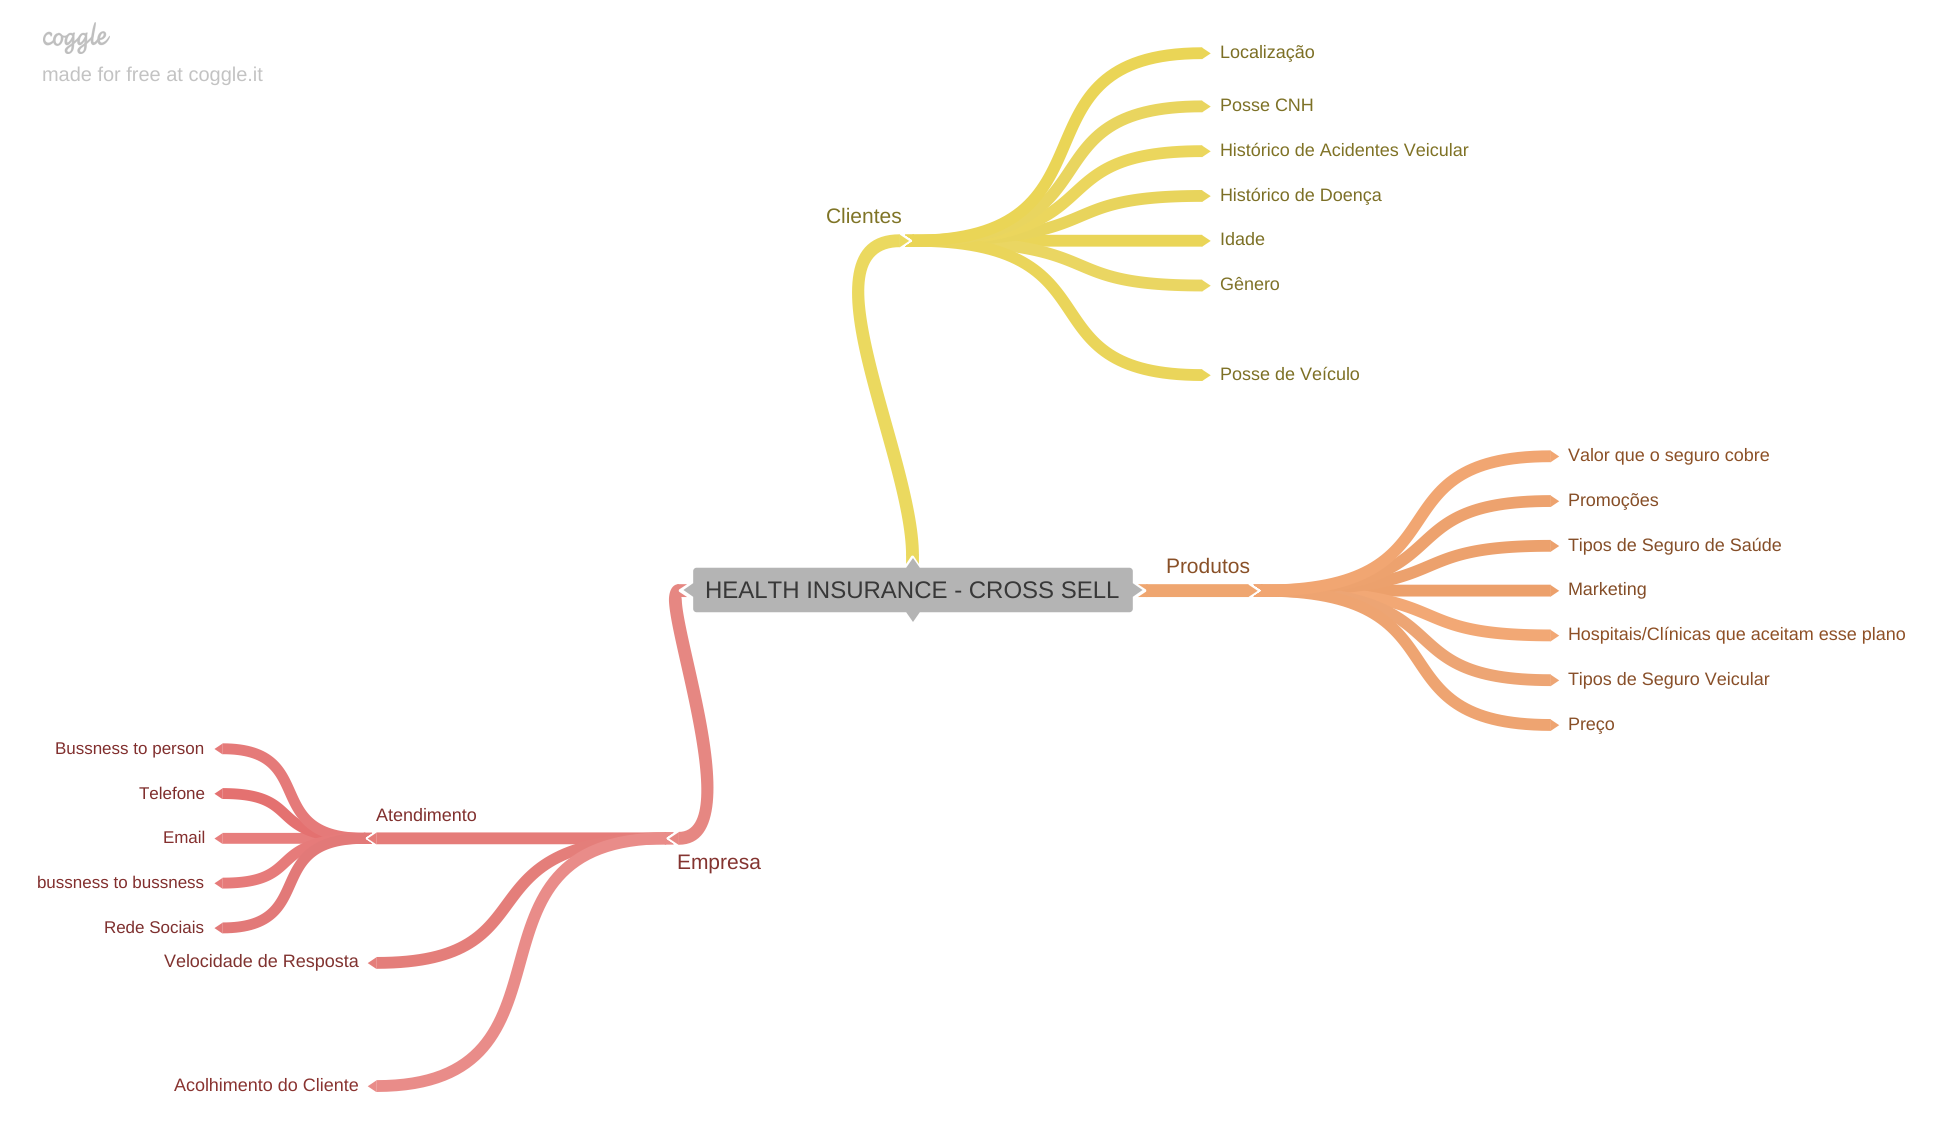

In [11]:
Image('feature_engineering.png')

### 2.2 Criação de Hipóteses

**1.** Clientes do gênero masculino aceitam mais o seguro veicular do que o gênero feminino.

**2.** Clientes do gênero feminino rejeitam mais o seguro veicular do que o gênero masculino.

**3.** Clientes que possuem Driving License aceitam mais o seguro do que os clientes que não possuem.

**4.** Clientes que possuem veículos com menos de 1 ano aceitam menos o seguro veicular.

**5.** Clientes em que seus veículos já foram danificados aceitam mais o seguro veicular.

**6.** Clientes que já possuem algum seguro veicular aceitam menos o seguro veicular.

**7.** Clientes com annual_premium menor que 35.000,00 aceitam menos o seguro veicular.

**8.** Clientes que estão a mais tempo com a empresa aceitam mais o seguro veicular.

**9.** Clientes com idade acima de 40 anos aceitam mais o seguro veicular.

# 3.0.  Passo 3 - Filtragem de Variáveis

In [12]:
df3 = df2.copy()

In [13]:
# gender
df3['gender'] = df3['gender'].apply(lambda x: x.lower())

# vehicle_damage
df3['vehicle_damage'] = df3['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# vehicle_age
df3['vehicle_age'] = df3['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' 
                                                  if x == '1-2 Year' else 'below_1_year')

# 4.0. Passo 4 - Análise Exploratória de Dados

In [14]:
df4 = df3.copy()

## 4.1 Análise Univariada

### Variável: 'age'

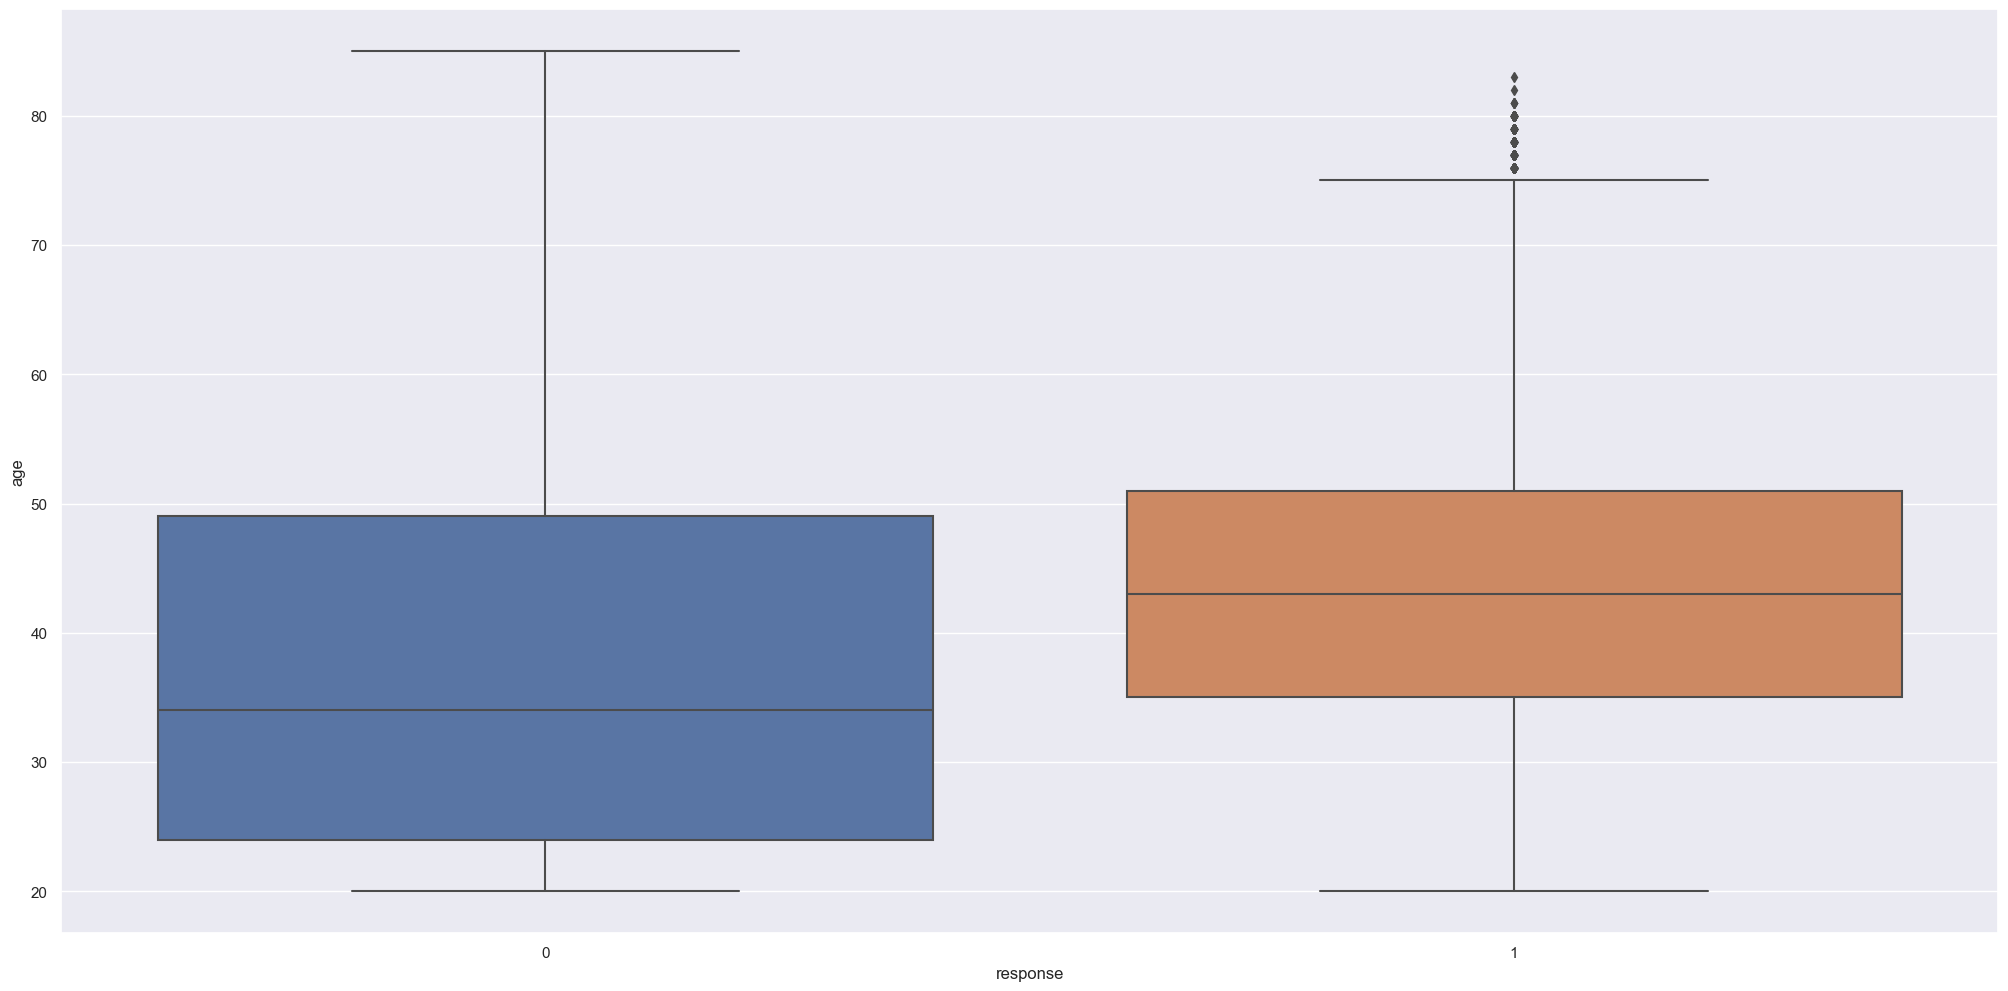

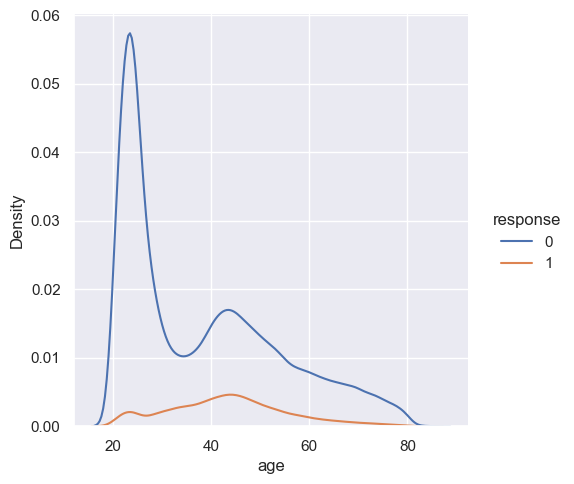

In [15]:
# age
# BOXPLOT
sns.boxplot(x='response', y='age', data=df4);
#DISTRIBUIÇÃO
sns.displot(df4, x='age', hue='response', kind='kde');

### Variável: 'annual_premium'

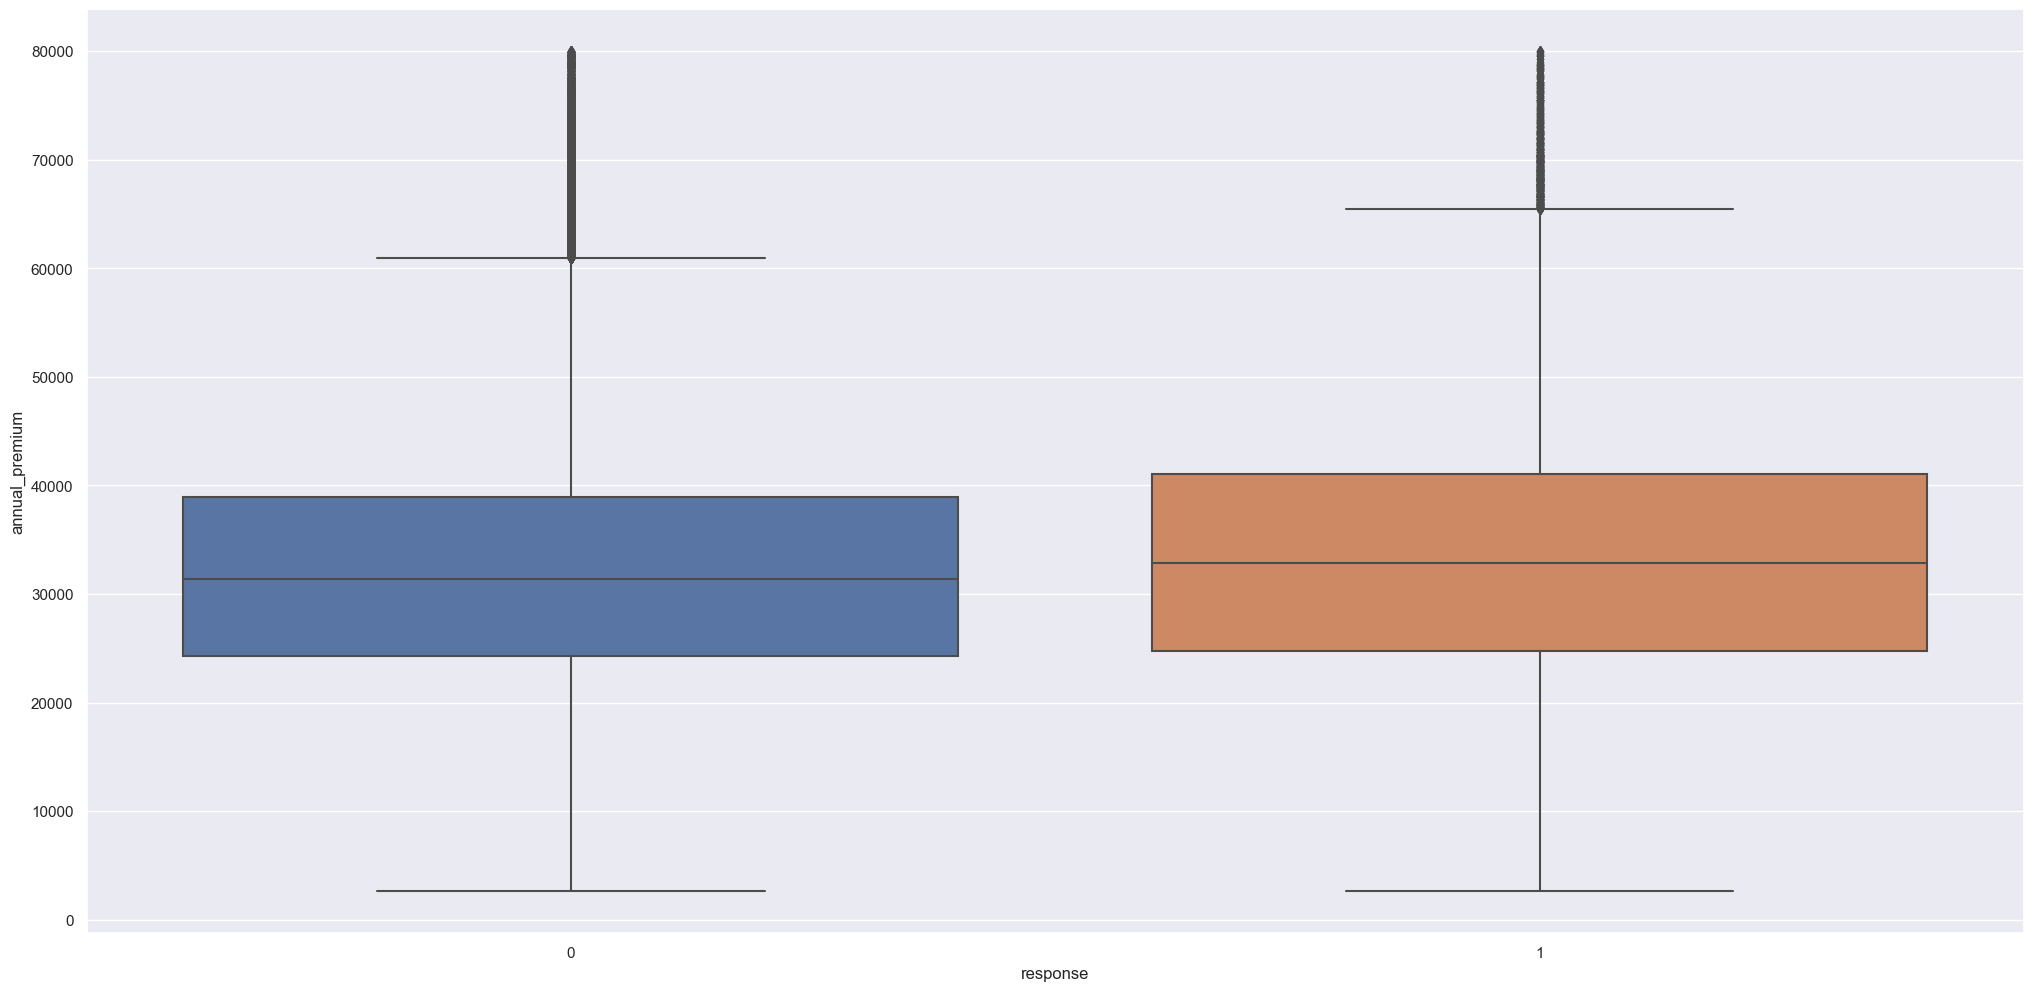

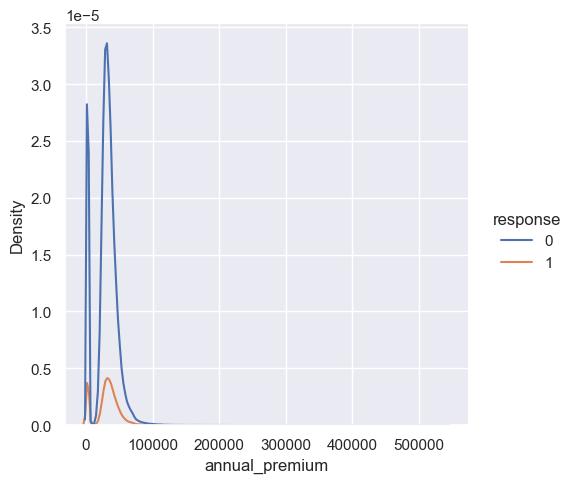

In [16]:
# annual_premium
aux = df4[df4['annual_premium'] < 80000]

# BOXPLOT
sns.boxplot(x='response', y='annual_premium', data=aux);

# DSITRIBUIÇÃO
sns.displot(df4, x='annual_premium', hue='response', kind='kde');

### Variável: 'driving_license'

In [17]:
# driving_license
aux = df4[['driving_license', 'response']].groupby('driving_license').count().reset_index()
aux['driving_license_percentual'] = aux['driving_license'] / np.sum(aux['driving_license'])

df_driving_license = pd.crosstab(df4['driving_license'], df4['response']).apply(lambda x: x/x.sum(), axis=1)


print(f"Clients without DL: {aux.loc[0, 'response']}")
print(f"Clients with DL:    {aux.loc[1, 'response']}")
df_driving_license

Clients without DL: 812
Clients with DL:    380297


response,0,1
driving_license,,
0,0.949507,0.050493
1,0.877283,0.122717


### Variável: 'region_code'

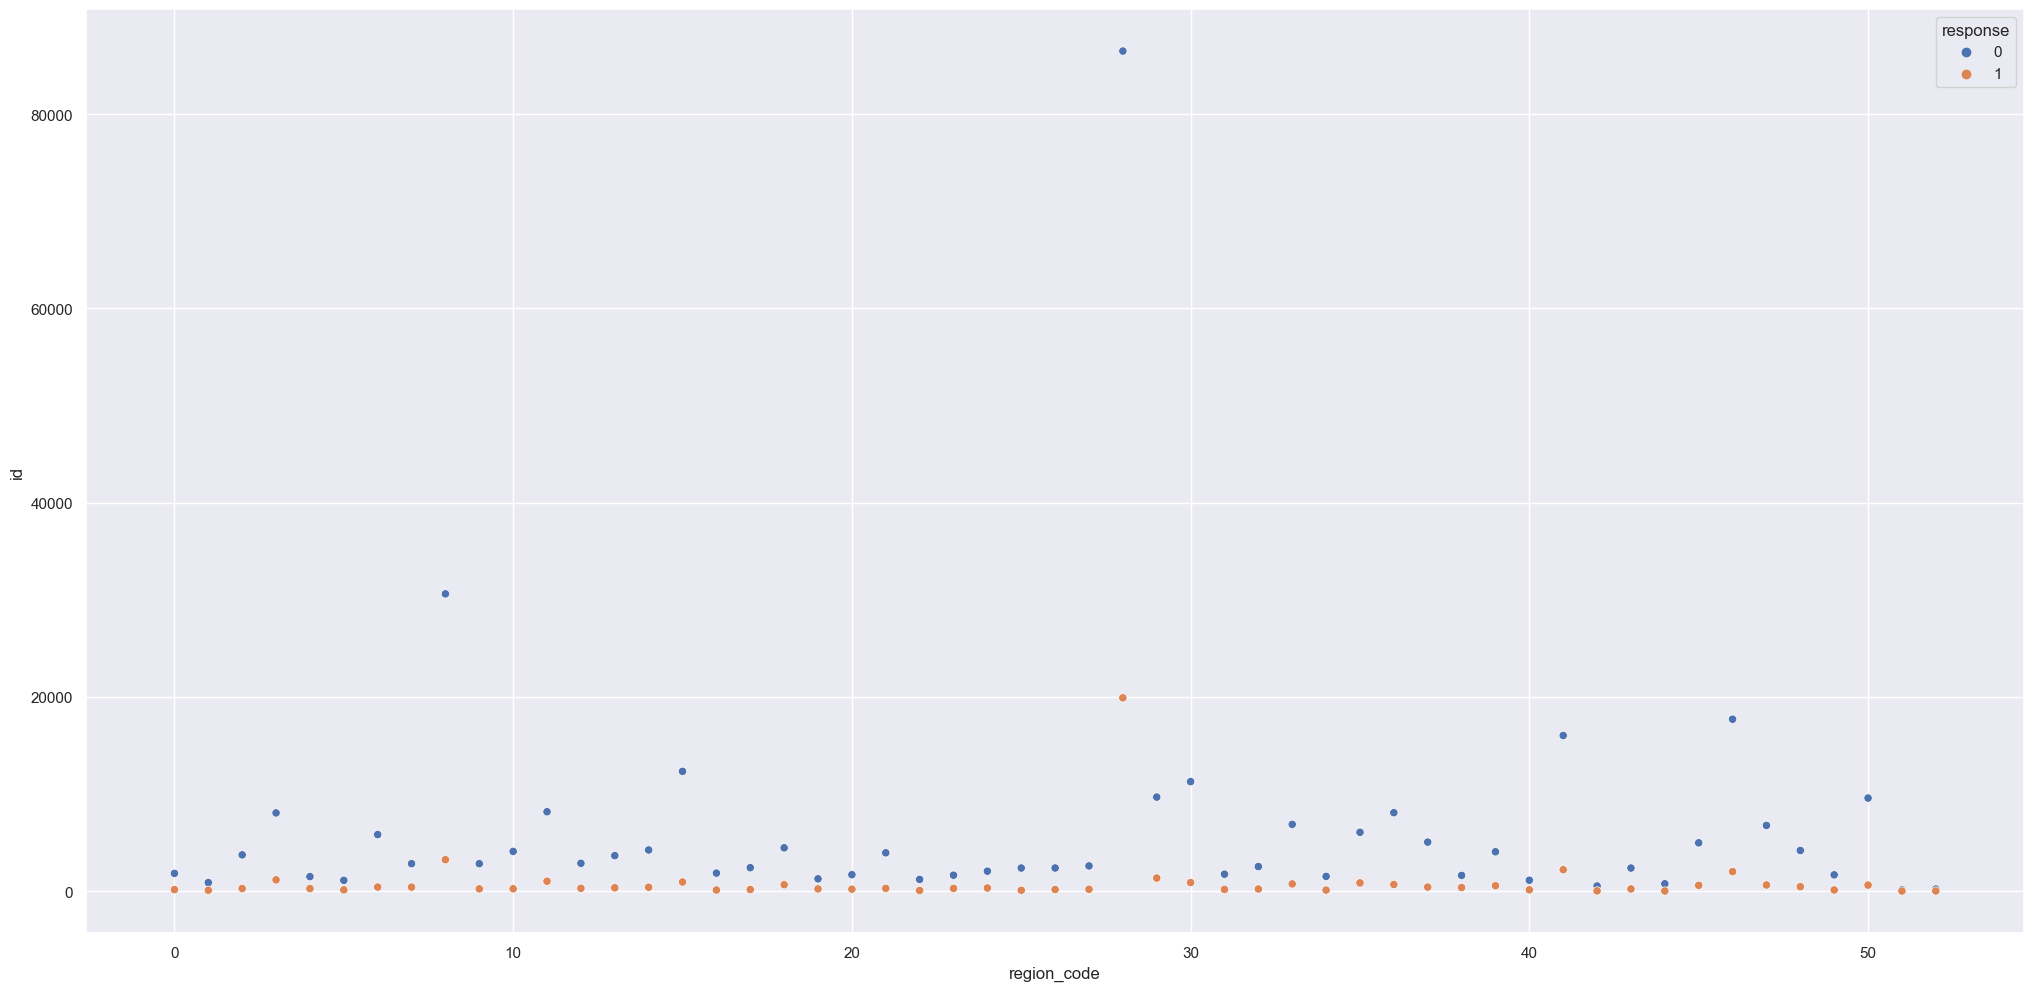

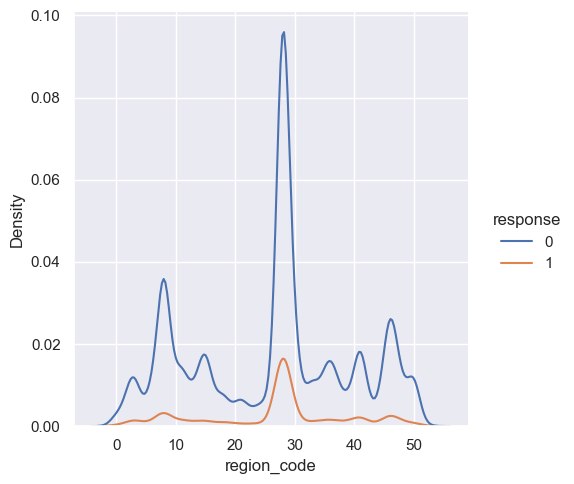

In [18]:
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

# SCATTER PLOT
sns.scatterplot(x='region_code', y='id', hue='response', data=aux);

# DISTRIBUIÇÃO
sns.displot(df4, x='region_code', hue='response', kind='kde');

### Variável: 'previously_insured'

In [19]:
# previously_insured
aux = df4[['previously_insured', 'response']].groupby('previously_insured').count().reset_index()

print(f"Clients dont´t previously_insured: {aux.loc[1, 'response']}")
print(f"Clients previously_insured: {aux.loc[0, 'response']}")

pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

Clients dont´t previously_insured: 174628
Clients previously_insured: 206481


response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [20]:
aux

,previously_insured,response
0,0,206481
1,1,174628


### Variável: 'policy_sales_channel'

In [21]:
aux = df4[['id', 'policy_sales_channel', 'response']].groupby(['policy_sales_channel', 'response']).count().reset_index()

plt.figure(figsize=(100,110))
sns.barplot(x='policy_sales_channel', y='id', hue='response', data=aux);

### Variável: 'vintage'

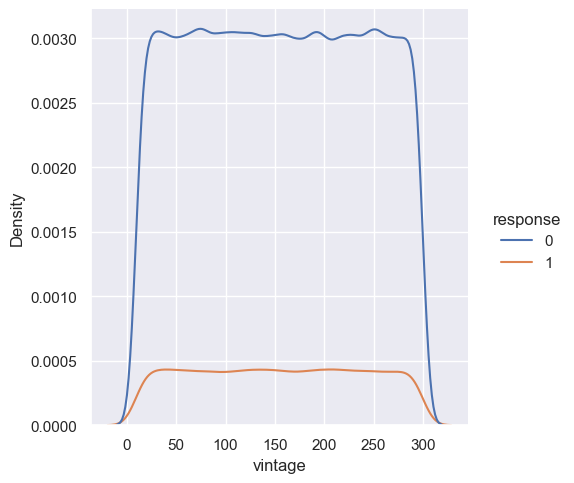

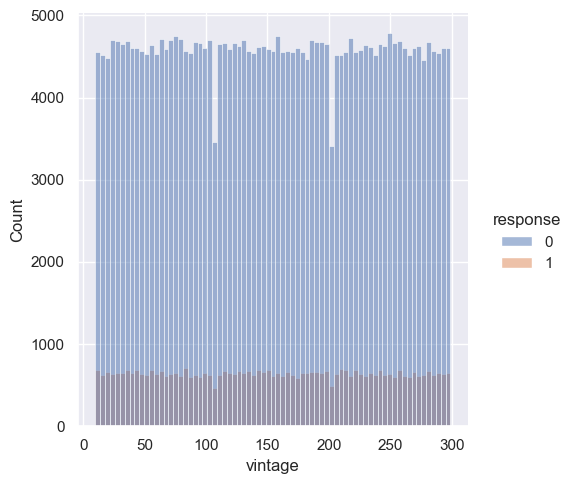

In [22]:
# vintage

# DISTRIBUIÇÃO DENSIDADE
sns.displot(df4, x='vintage', hue='response', kind='kde');

# HISTOGRAMA
sns.displot(df4, x='vintage', hue='response', kind='hist');

### Variável: vehicle_age

In [23]:
# vehicle_age
aux = df4[['vehicle_age', 'response']].groupby('vehicle_age').count().reset_index()

print(f"Clients with car below 1 year: {aux.loc[0, 'response']}")
print(f"Clients with car between 1-2 years: {aux.loc[1, 'response']}")
print(f"Clients with car over 2 years: {aux.loc[2, 'response']}")

pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

Clients with car below 1 year: 164786
Clients with car between 1-2 years: 200316
Clients with car over 2 years: 16007


response,0,1
vehicle_age,,
below_1_year,0.956295,0.043705
between_1_2_years,0.826245,0.173755
over_2_years,0.706254,0.293746


### Variável: vehicle_damage

In [24]:
# 'vehicle_damage'
aux = df4[['vehicle_damage', 'response']].groupby('vehicle_damage').count().reset_index()

print(f"Clients hasn't car damage: {aux.loc[1, 'response']}")
print(f"Clients has car damage: {aux.loc[0, 'response']}")
    
pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

Clients hasn't car damage: 192413
Clients has car damage: 188696


response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


### Variável: gender

In [25]:
#'gender'
aux = df4[['gender', 'response']].groupby('gender').count().reset_index()

print(f"Clients female: {aux.loc[0, 'response']}")
print(f"Clients male: {aux.loc[1, 'response']}")


pd.crosstab(df4['gender'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

Clients female: 175020
Clients male: 206089


response,0,1
gender,,
female,0.896098,0.103902
male,0.861589,0.138411


## 4.2 Análise Multivariada

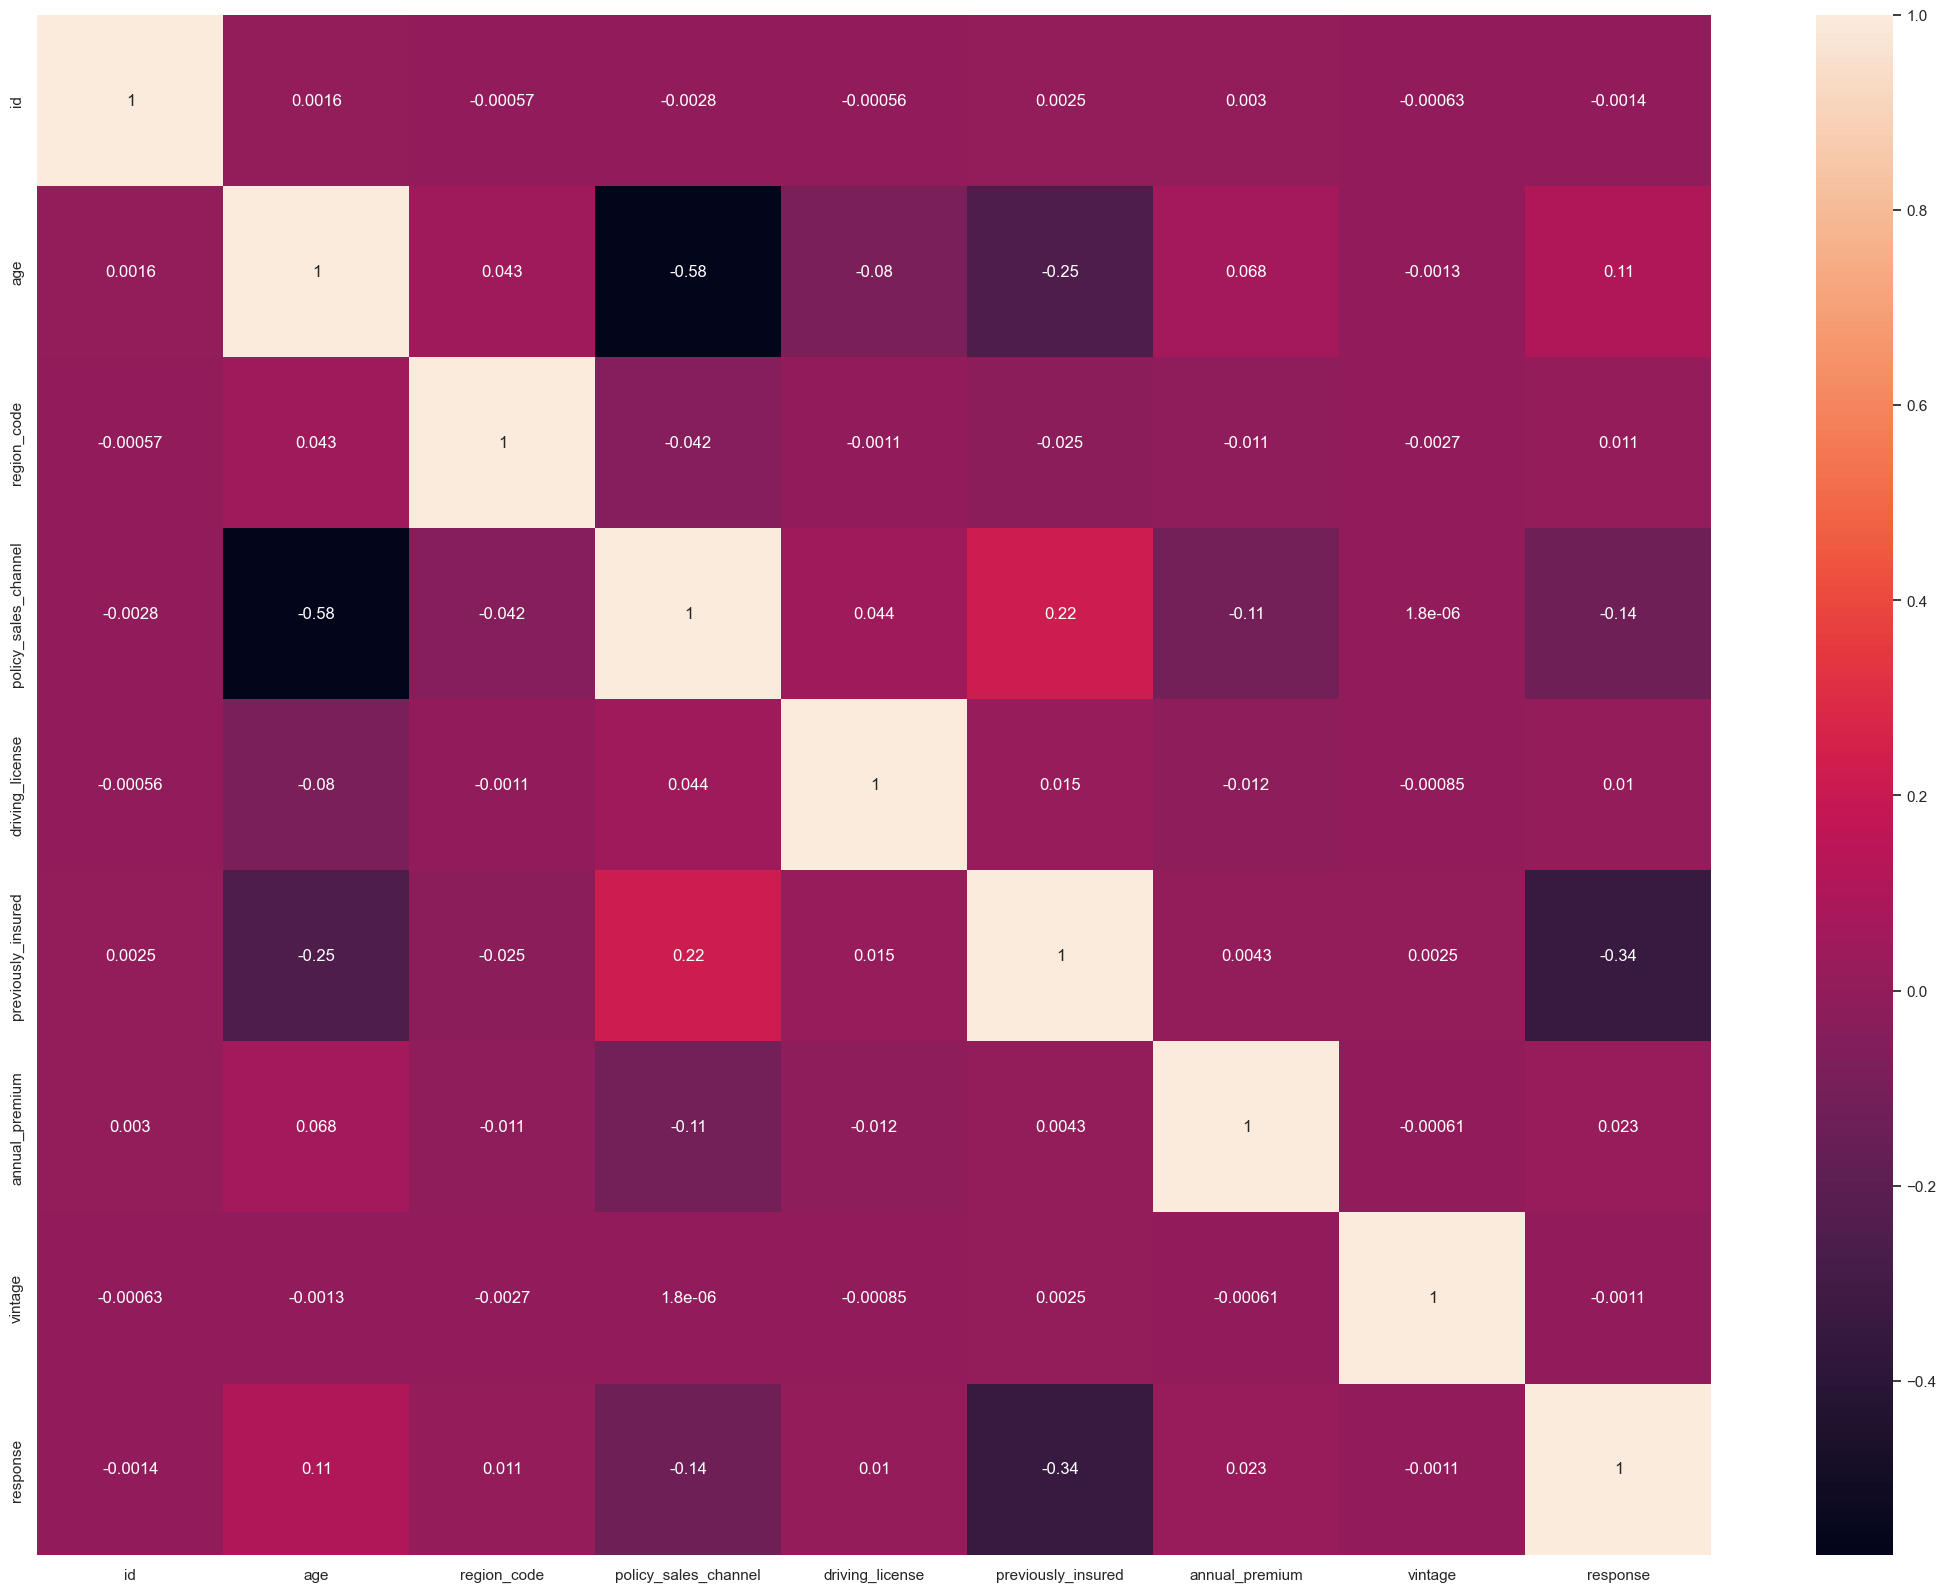

In [26]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(27,20))
sns.heatmap(correlation, annot=True);

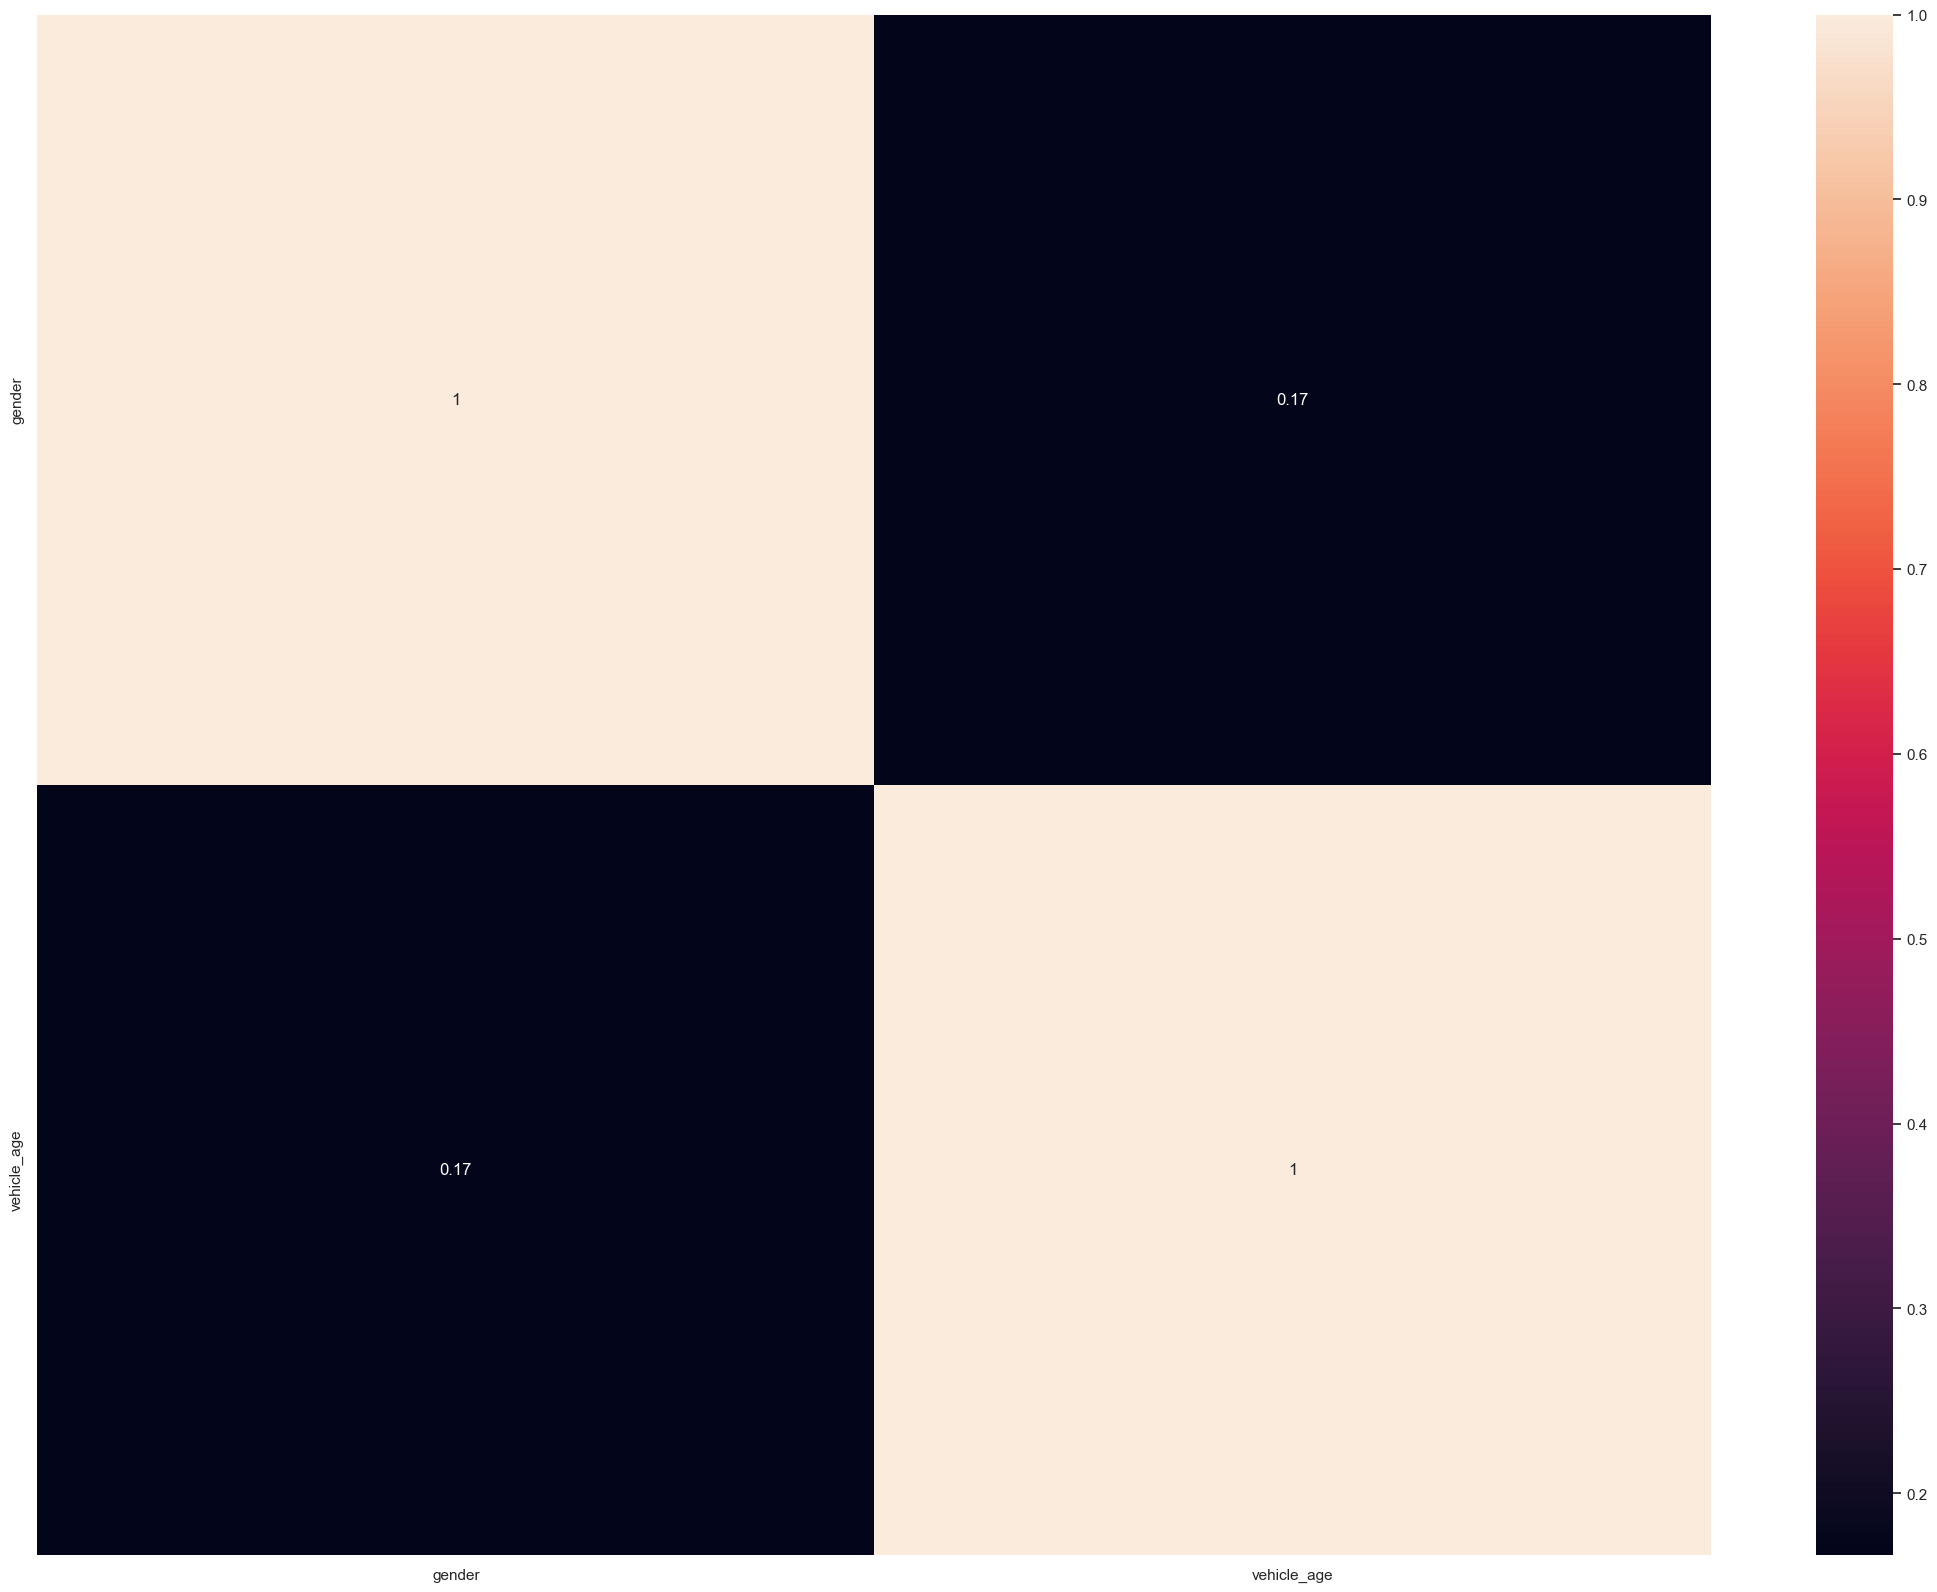

In [27]:
cat = df4.select_dtypes(include='object')
a1 = cramer_v(cat['gender'], cat['gender'])
a2 = cramer_v(cat['gender'], cat['vehicle_age'])

b1 = cramer_v(cat['vehicle_age'], cat['vehicle_age'])
b2 = cramer_v(cat['vehicle_age'], cat['gender'])

d = pd.DataFrame({'gender':[a1, a2], 
              'vehicle_age': [b2, b1]})

d = d.set_index(d.columns)

plt.figure(figsize = (27,20))
sns.heatmap(d, annot=True);

### age

#### Variável: vintage -> age

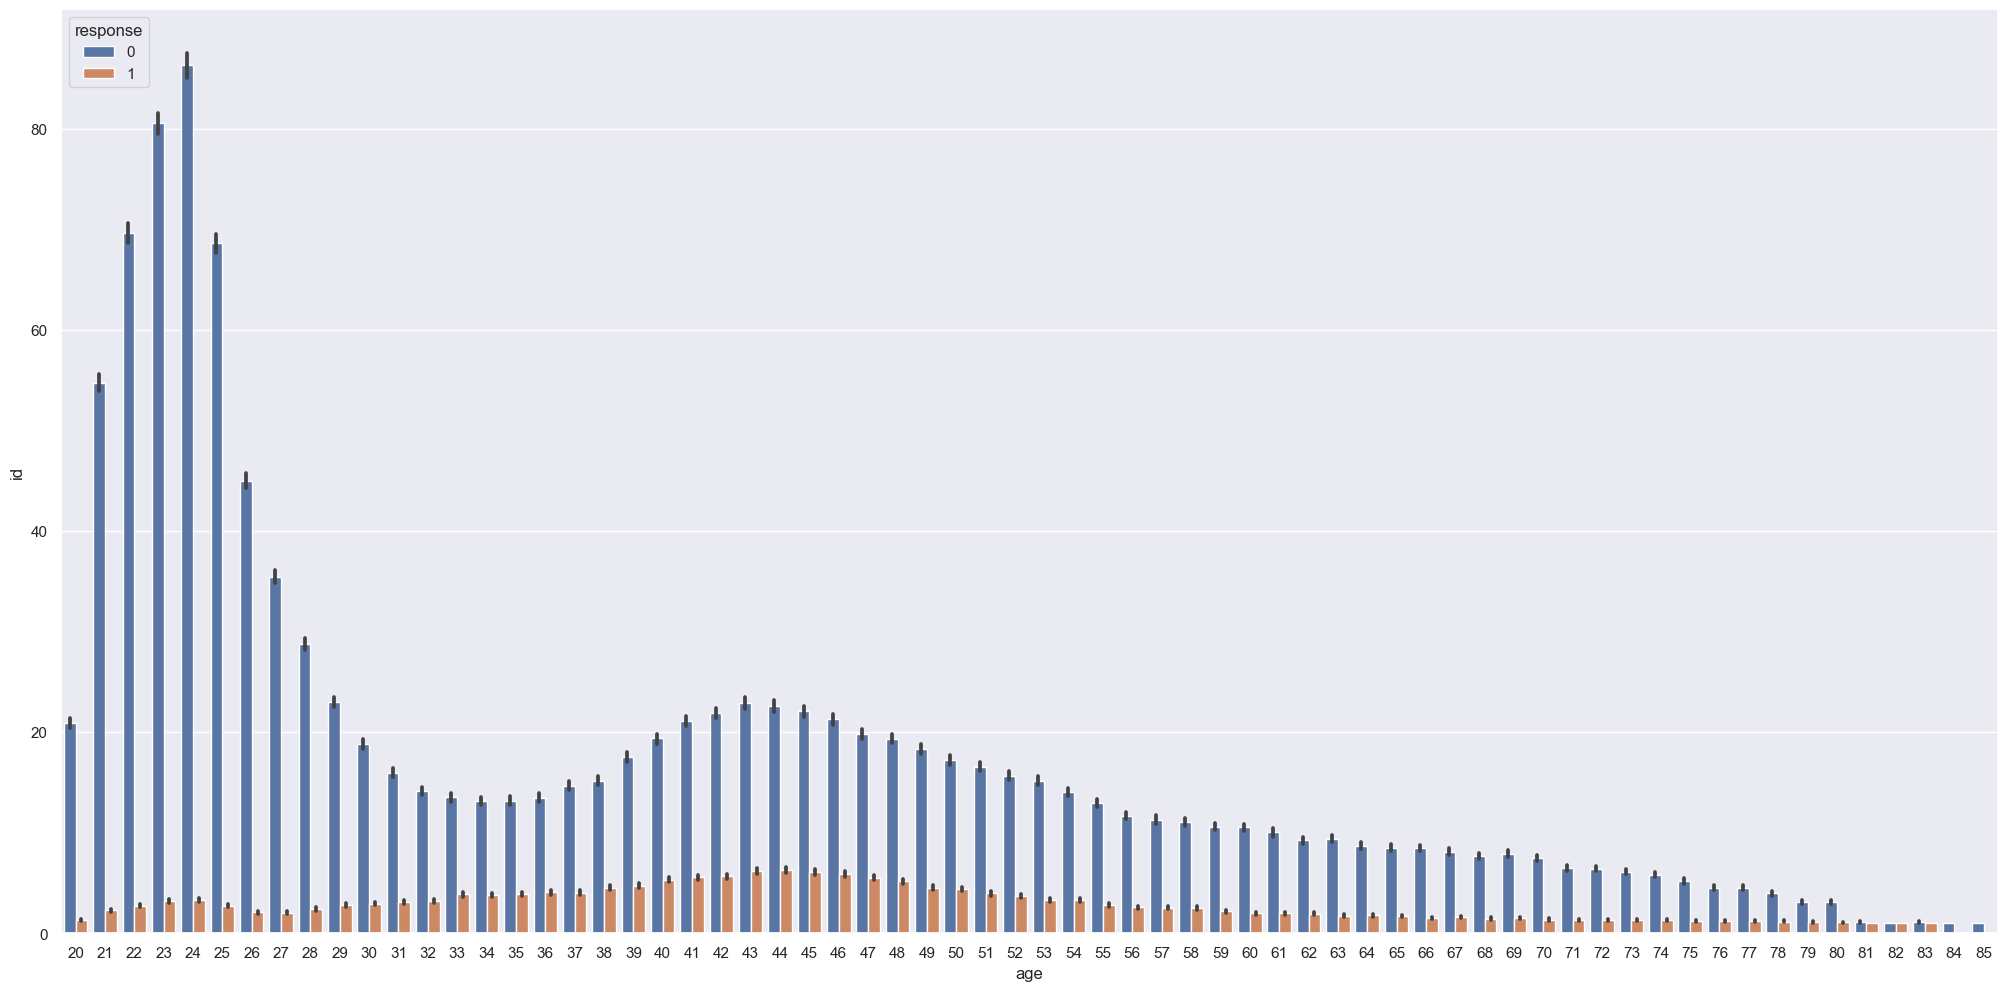

In [28]:
aux = df4[['id','age', 'vintage', 'response']].groupby(['age', 'vintage', 'response']).count().reset_index()

plt.subplot(1,1,1)
#age
sns.barplot(x='age', y='id', hue='response', data=aux);

#### Variável: annual_premium -> age

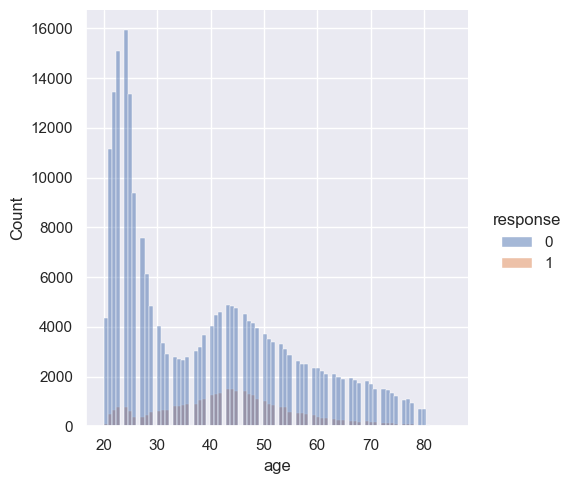

In [29]:
aux = df4[['id','age', 'annual_premium', 'response']].groupby(['age', 'annual_premium', 'response']).count().reset_index()

# Distribuição
sns.displot(aux, x='age', hue='response', kind='hist');

####  Variável: region_code -> age

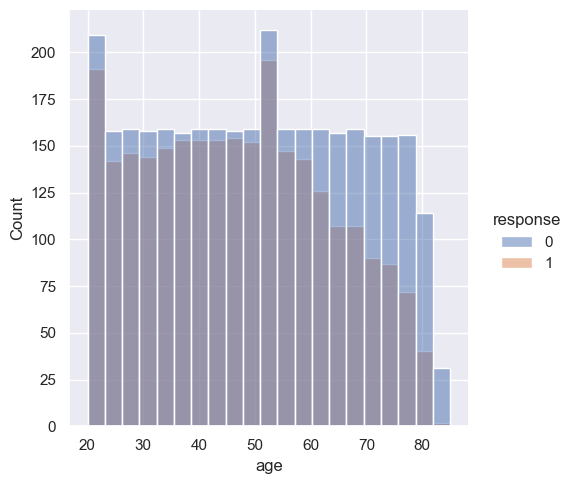

In [30]:
aux = df4[['id','age', 'region_code', 'response']].groupby(['age', 'region_code', 'response']).count().reset_index()

# Distribuição
sns.displot(aux, x='age', hue='response', kind='hist');

#### Variável: driving_license -> age

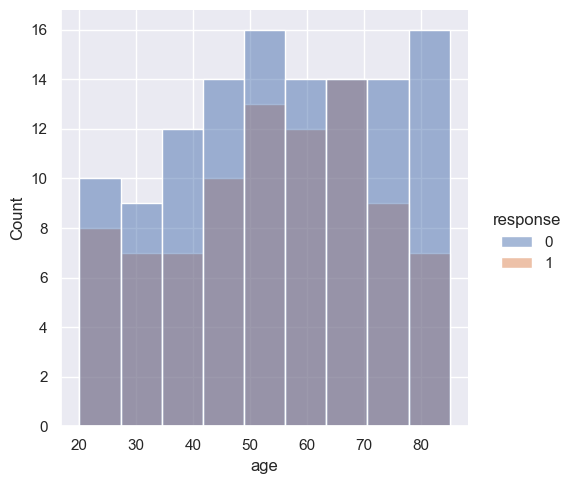

In [31]:
aux = df4[['id','age', 'driving_license', 'response']].groupby(['age', 'driving_license', 'response']).count().reset_index()

# Distribuição
sns.displot(aux, x='age', hue='response', kind='hist');

#### Variável: policy_sales_channel -> age

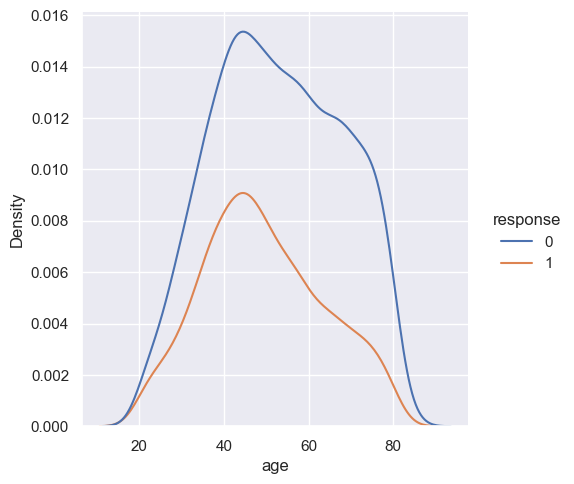

In [32]:
aux = df4[['id','age', 'policy_sales_channel', 'response']].groupby(['age', 'policy_sales_channel', 'response']).count().reset_index()

# Distribuição
sns.displot(aux, x='age', hue='response', kind='kde');

#### Variável: previously_insured -> age

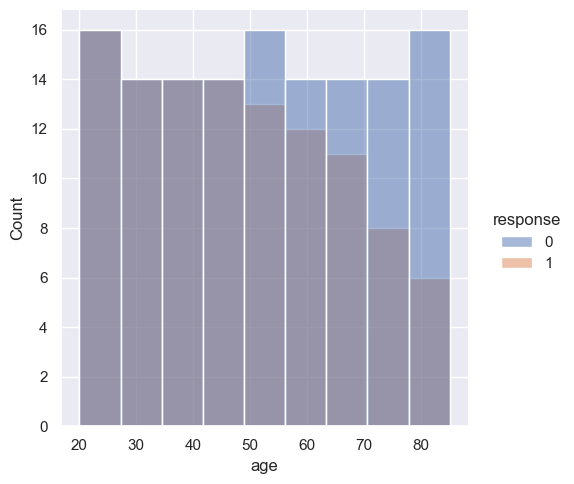

In [33]:
aux = df4[['id','age', 'previously_insured', 'response']].groupby(['age', 'previously_insured', 'response']).count().reset_index()

# Distribuição
sns.displot(aux, x='age', hue='response', kind='hist');

### annual_premium 

#### Variável: previously_insured -> annual_premium 

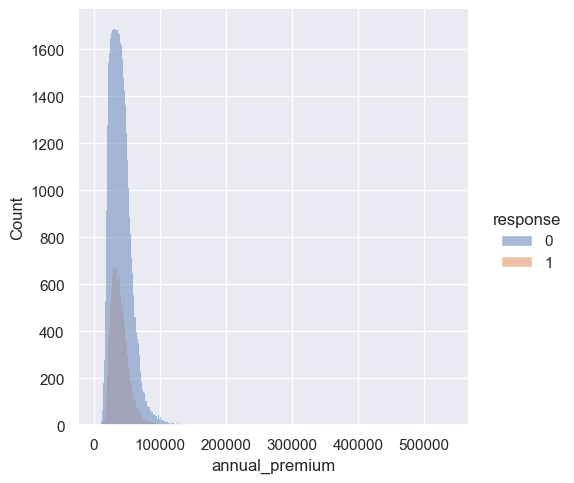

In [34]:
aux = df4[['id','previously_insured', 'annual_premium', 'response']].groupby(['annual_premium', 'previously_insured', 'response']).count().reset_index()

sns.displot(aux, x='annual_premium', hue='response', kind='hist');

#### Variável: Vintage -> annual_premium

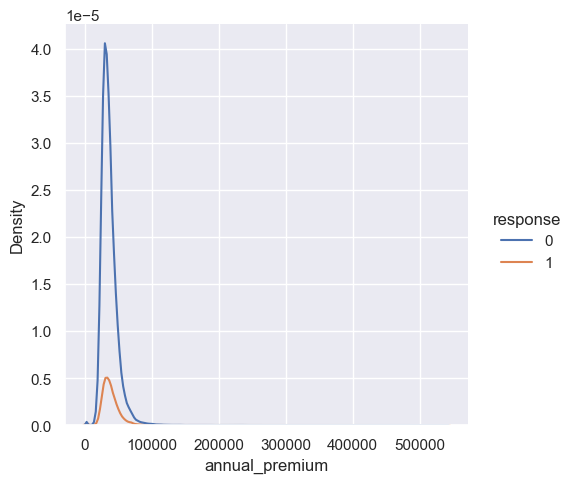

In [35]:
aux = df4[['id', 'vintage', 'annual_premium', 'response']].groupby(['annual_premium', 'vintage', 'response']).count().reset_index()

sns.displot(aux, x='annual_premium', hue='response', kind='kde');

#### Variável: driving_license -> annual_premium

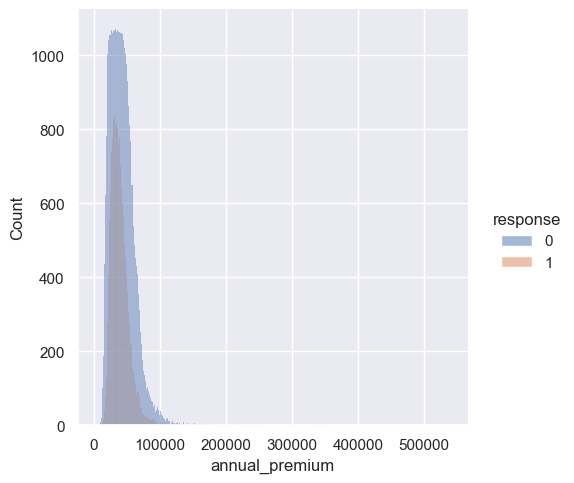

In [36]:
aux = df4[['id', 'driving_license', 'annual_premium', 'response']].groupby(['annual_premium', 'driving_license', 'response']).count().reset_index()

sns.displot(aux, x='annual_premium', hue='response', kind='hist');

#### Variável: policy_sales_channel -> annual_premium

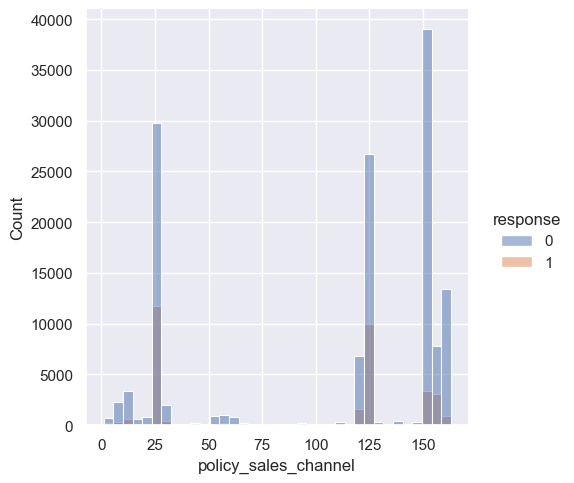

In [37]:
aux = df4[['id', 'annual_premium', 'policy_sales_channel', 'response']].groupby(['annual_premium', 'policy_sales_channel', 'response']).count().reset_index()

sns.displot(aux, x='policy_sales_channel', hue='response');

#### Variável: region code -> annual_premium

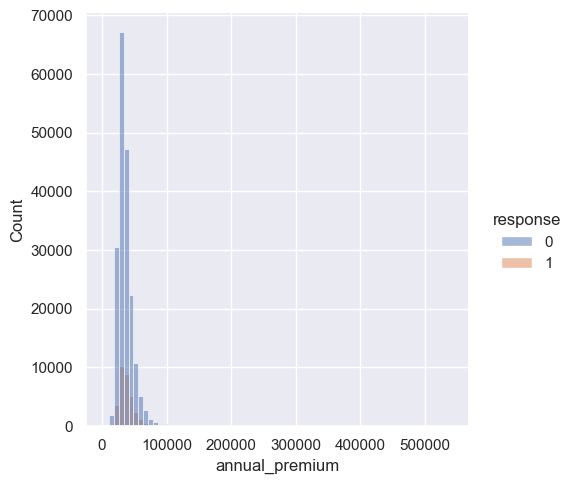

In [38]:
aux = df4[['id', 'annual_premium', 'region_code', 'response']].groupby(['annual_premium', 
                                                                        'region_code',
                                                                        'response']).count().reset_index()

sns.displot(aux, x='annual_premium', hue='response', bins=70);

### vintage

#### Variável: previously_insured -> vintage

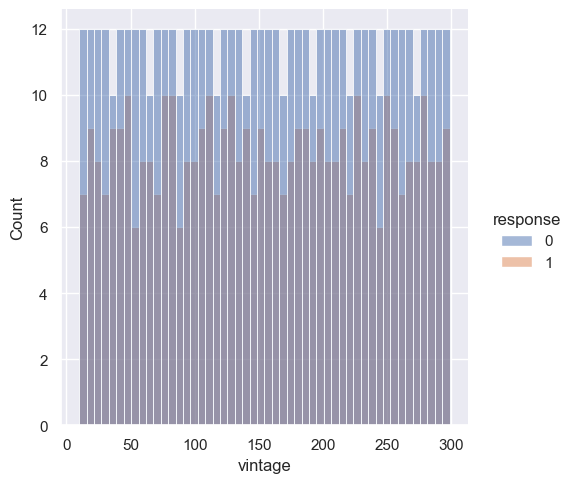

In [39]:
aux = df4[['id', 'vintage', 'previously_insured', 'response']].groupby(['vintage', 'previously_insured', 'response']).count().reset_index()

sns.displot(aux, x='vintage', hue='response', bins=50);

#### Variável: driving_license -> vintage

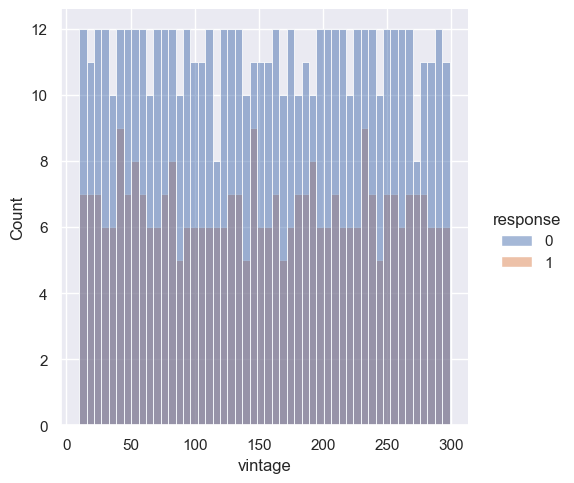

In [40]:
aux = df4[['id', 'vintage', 'driving_license', 'response']].groupby(['vintage', 'driving_license', 'response']).count().reset_index()

sns.displot(aux, x='vintage', hue='response', bins=50);

#### Variável: policy_sales_channel -> vintage

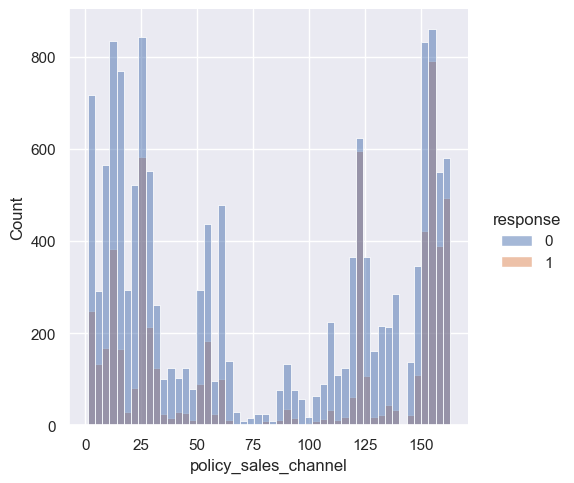

In [41]:
aux = df4[['id', 'vintage', 'policy_sales_channel', 'response']].groupby(['vintage', 'policy_sales_channel', 'response']).count().reset_index()

sns.displot(aux, x='policy_sales_channel', hue='response', bins=50);

#### Variável: region_code -> vintage

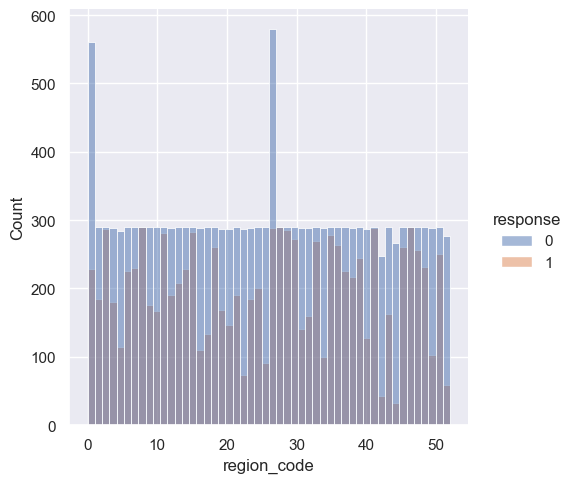

In [42]:
aux = df4[['id', 'vintage', 'region_code', 'response']].groupby(['vintage', 'region_code', 'response']).count().reset_index()

sns.displot(aux, x='region_code', hue='response', bins=50);

## 4.3 Validação de Hipóteses

**H1.** Clientes do gênero masculino deveriam aceitam mais o seguro veicular do que o gênero feminino.

**RESPOSTA:** Essa afirmação é verdadeira.

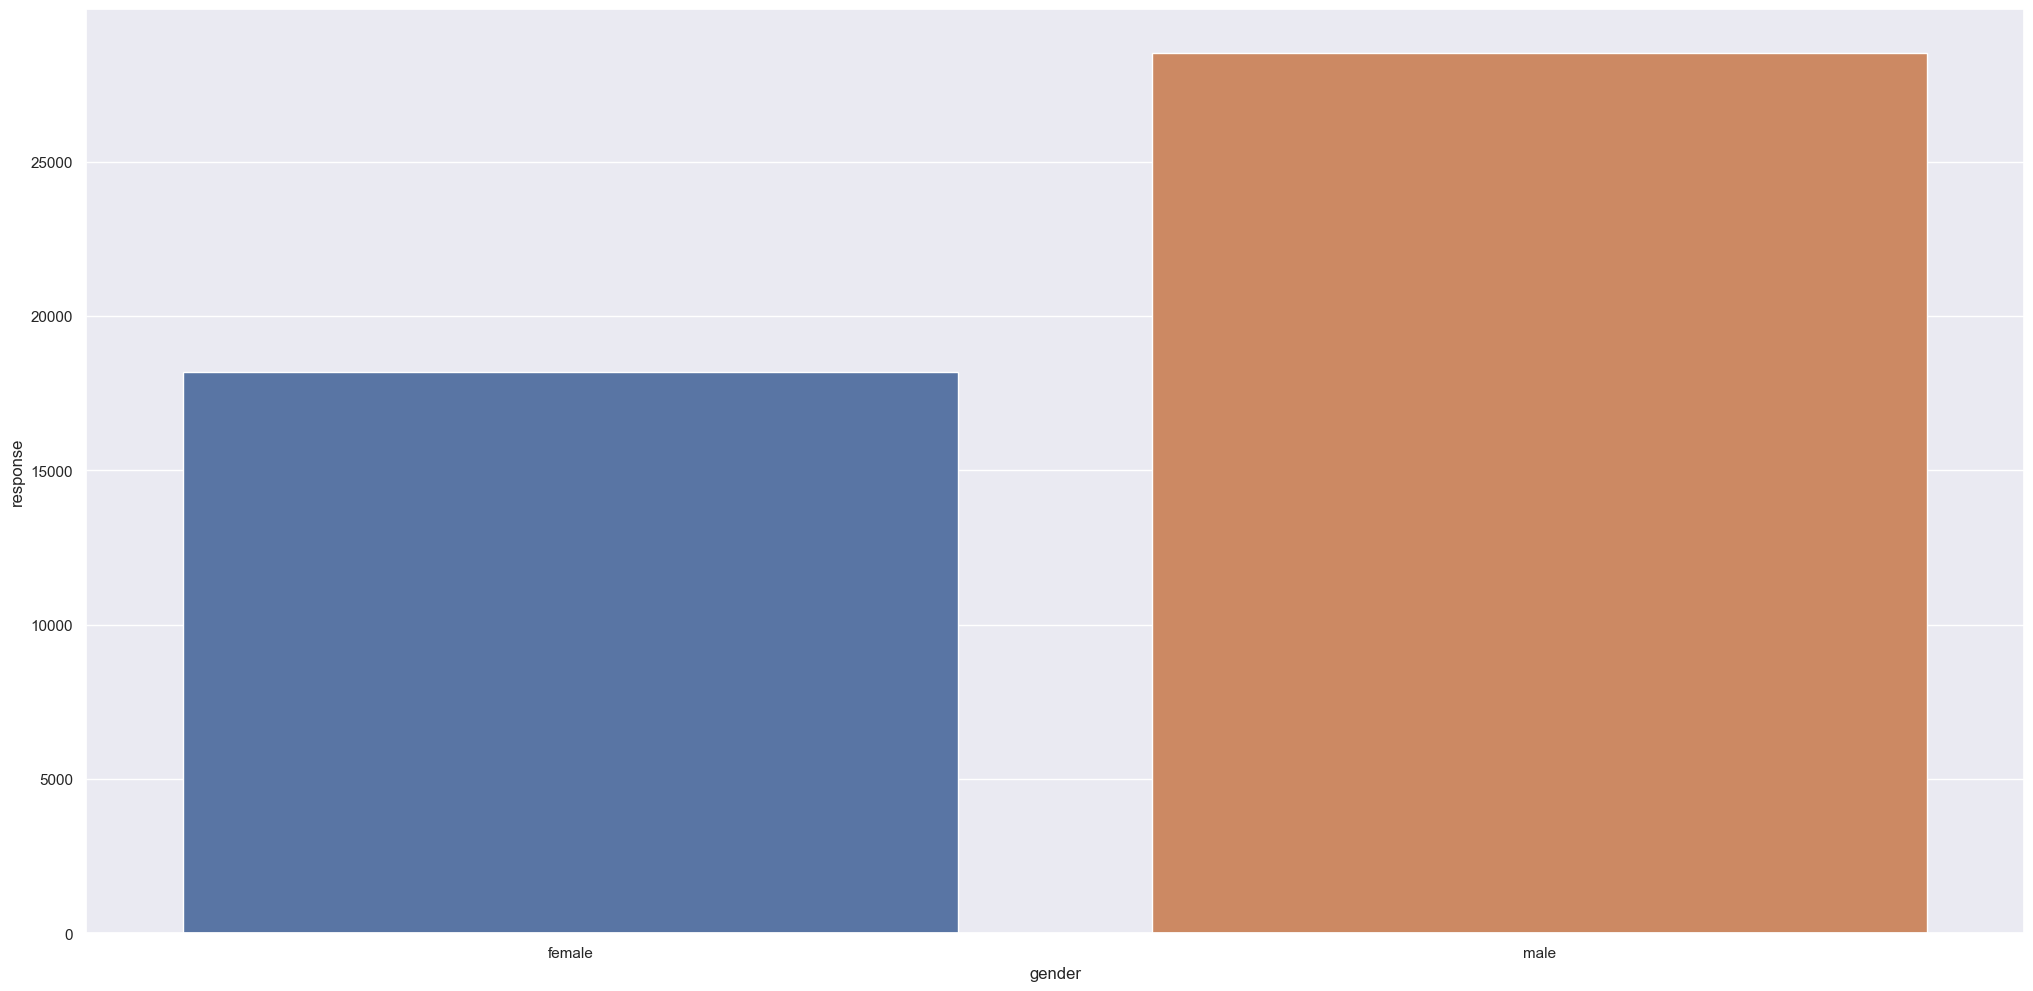

In [43]:
# Organização dos dados
df_h1 = df4[['gender', 'response']][df4['response'] == 1].groupby('gender').count().reset_index()

# Construção do gráfico para visualização
sns.barplot(x='gender', y='response', data=df_h1);

**H2.** Clientes do gênero feminino rejeitam mais o seguro veicular do que o gênero masculino.

**RESPOSTA:** Essa afirmação é falsa. Os clientes do gênero masculino rejeitam mais o seguro veicular do que as mulheres, por uma pequena diferença de 20000 clientes.

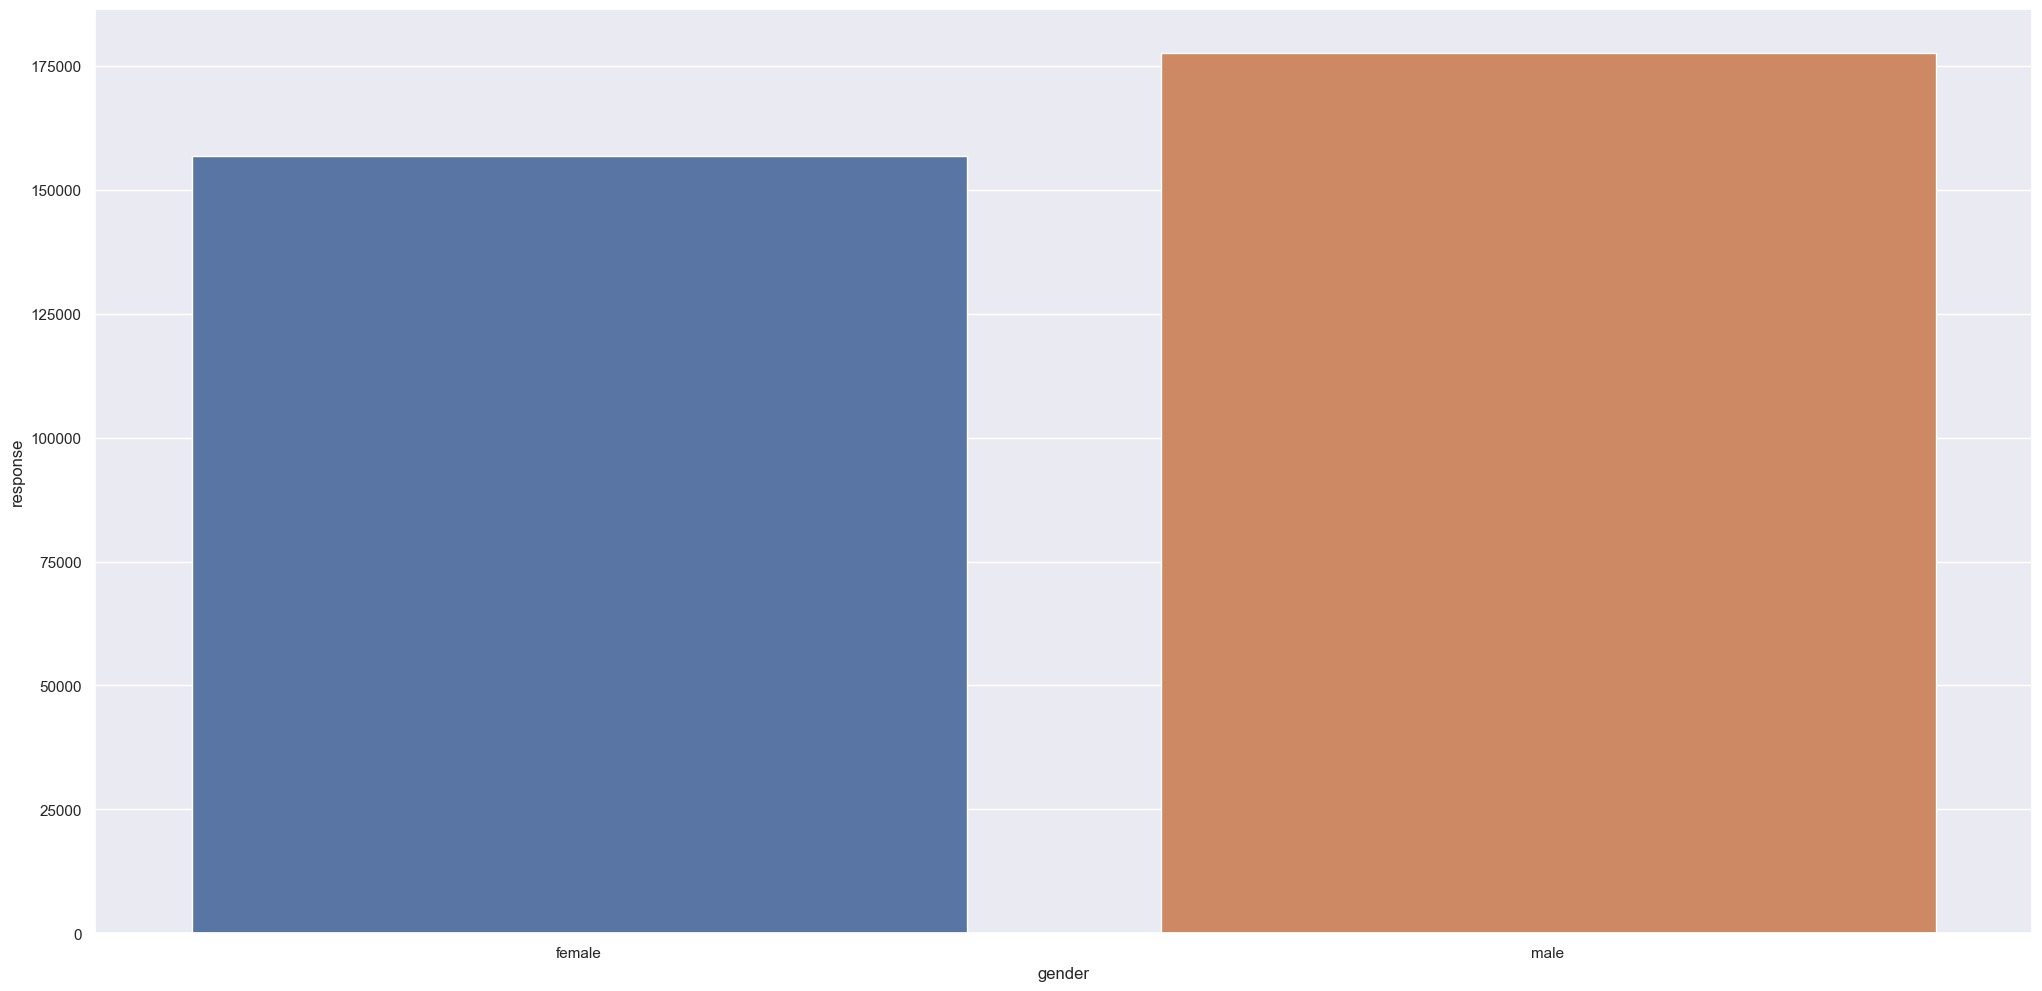

In [44]:
# Organização dos dados
df_h2 = df4[['gender', 'response']][df4['response'] == 0].groupby('gender').count().reset_index()

# Construção do gráfico para visualização
sns.barplot(x='gender', y='response', data=df_h2);

**H3.** Clientes que possuem Driving License aceitam mais o seguro do que os clientes que não possuem.

<AxesSubplot: xlabel='driving_license', ylabel='response'>

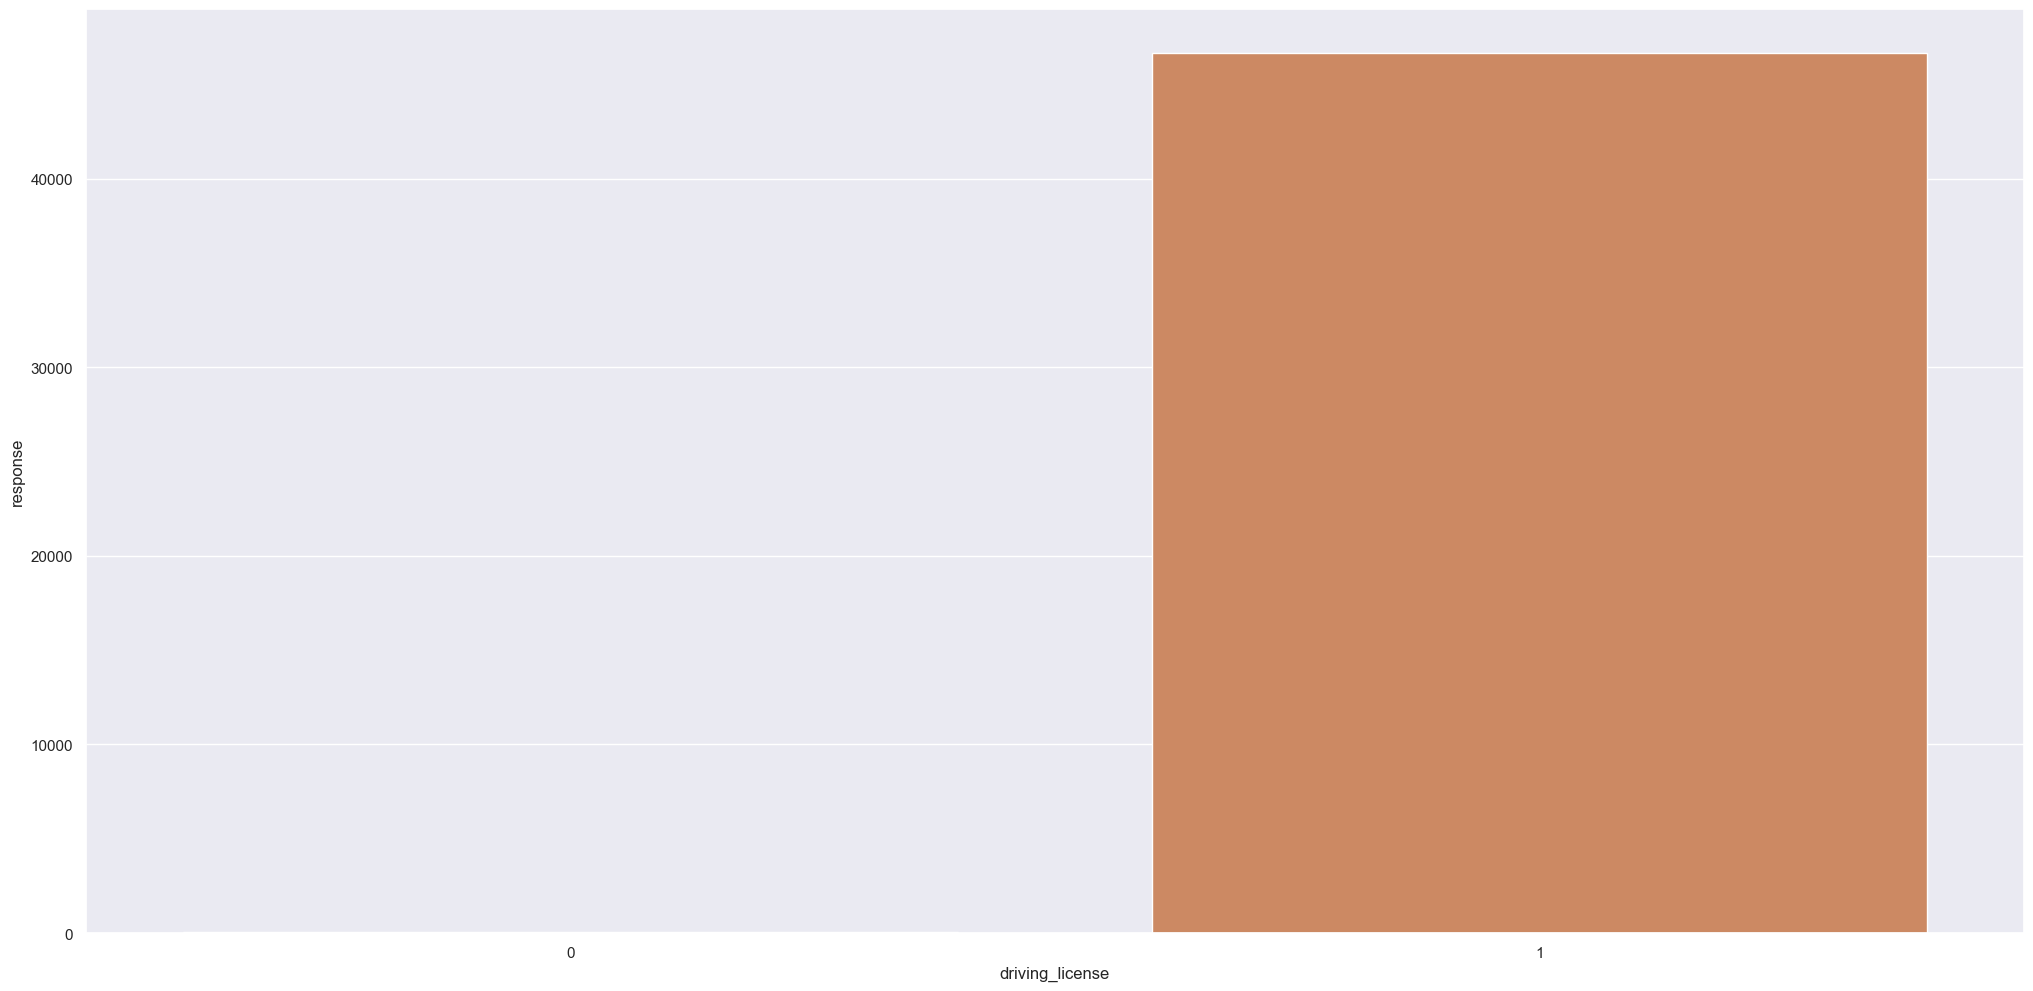

In [45]:
df_h3 = df4[['driving_license', 'response']][df4['response'] == 1].groupby('driving_license').count().reset_index()

sns.barplot(x='driving_license', y='response', data=df_h3)

**H4.** Clientes que possuem veículos com menos de 1 ano aceitam menos o seguro veicular.

**RESPOSTA**: Essa afirmação é falsa. Clientes veículos com de mais de 2 anos aceitam menos o seguro veicular.

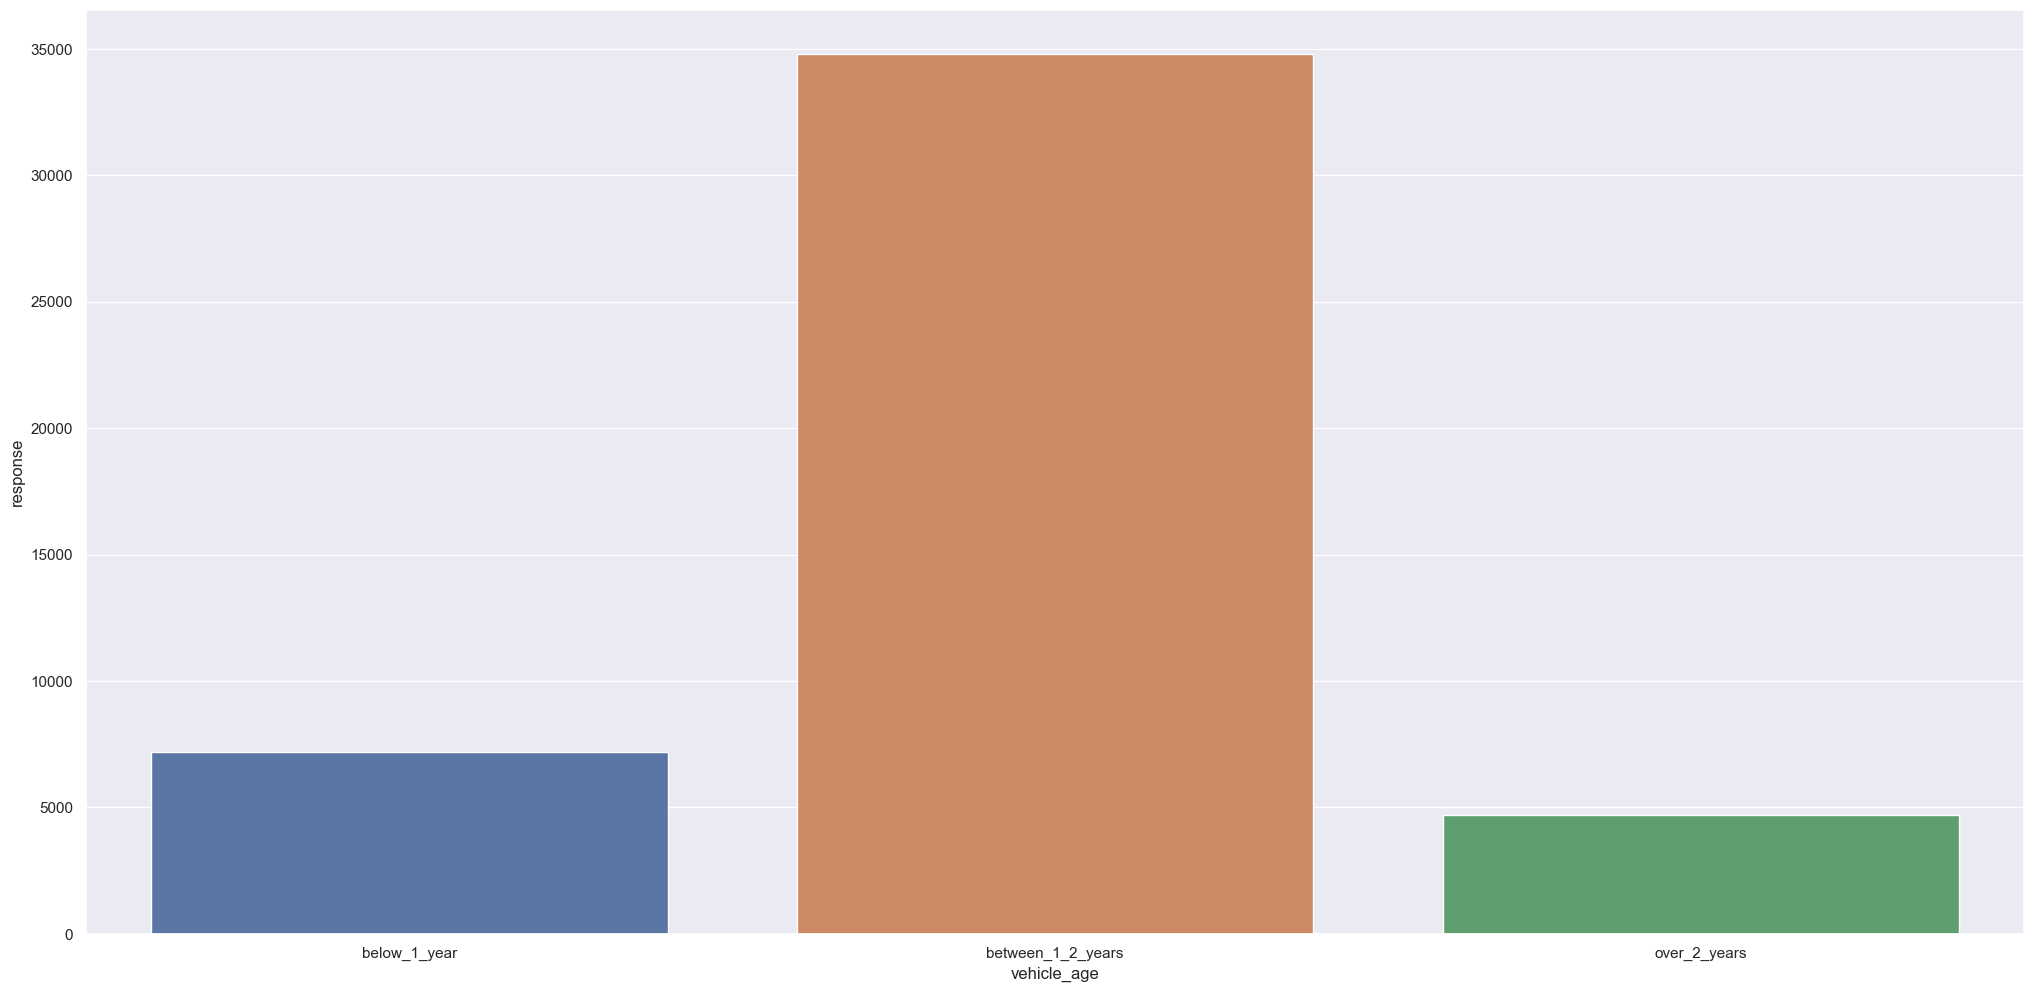

In [46]:
df_h4 = df4[['vehicle_age', 'response']][df4['response'] == 1].groupby('vehicle_age').count().reset_index()

sns.barplot(x='vehicle_age', y='response', data=df_h4);

**H5.** Clientes em que seus veículos já foram danificados aceitam mais o seguro veicular.

**RESPOSTA:** Essa afirmação é verdadeira.

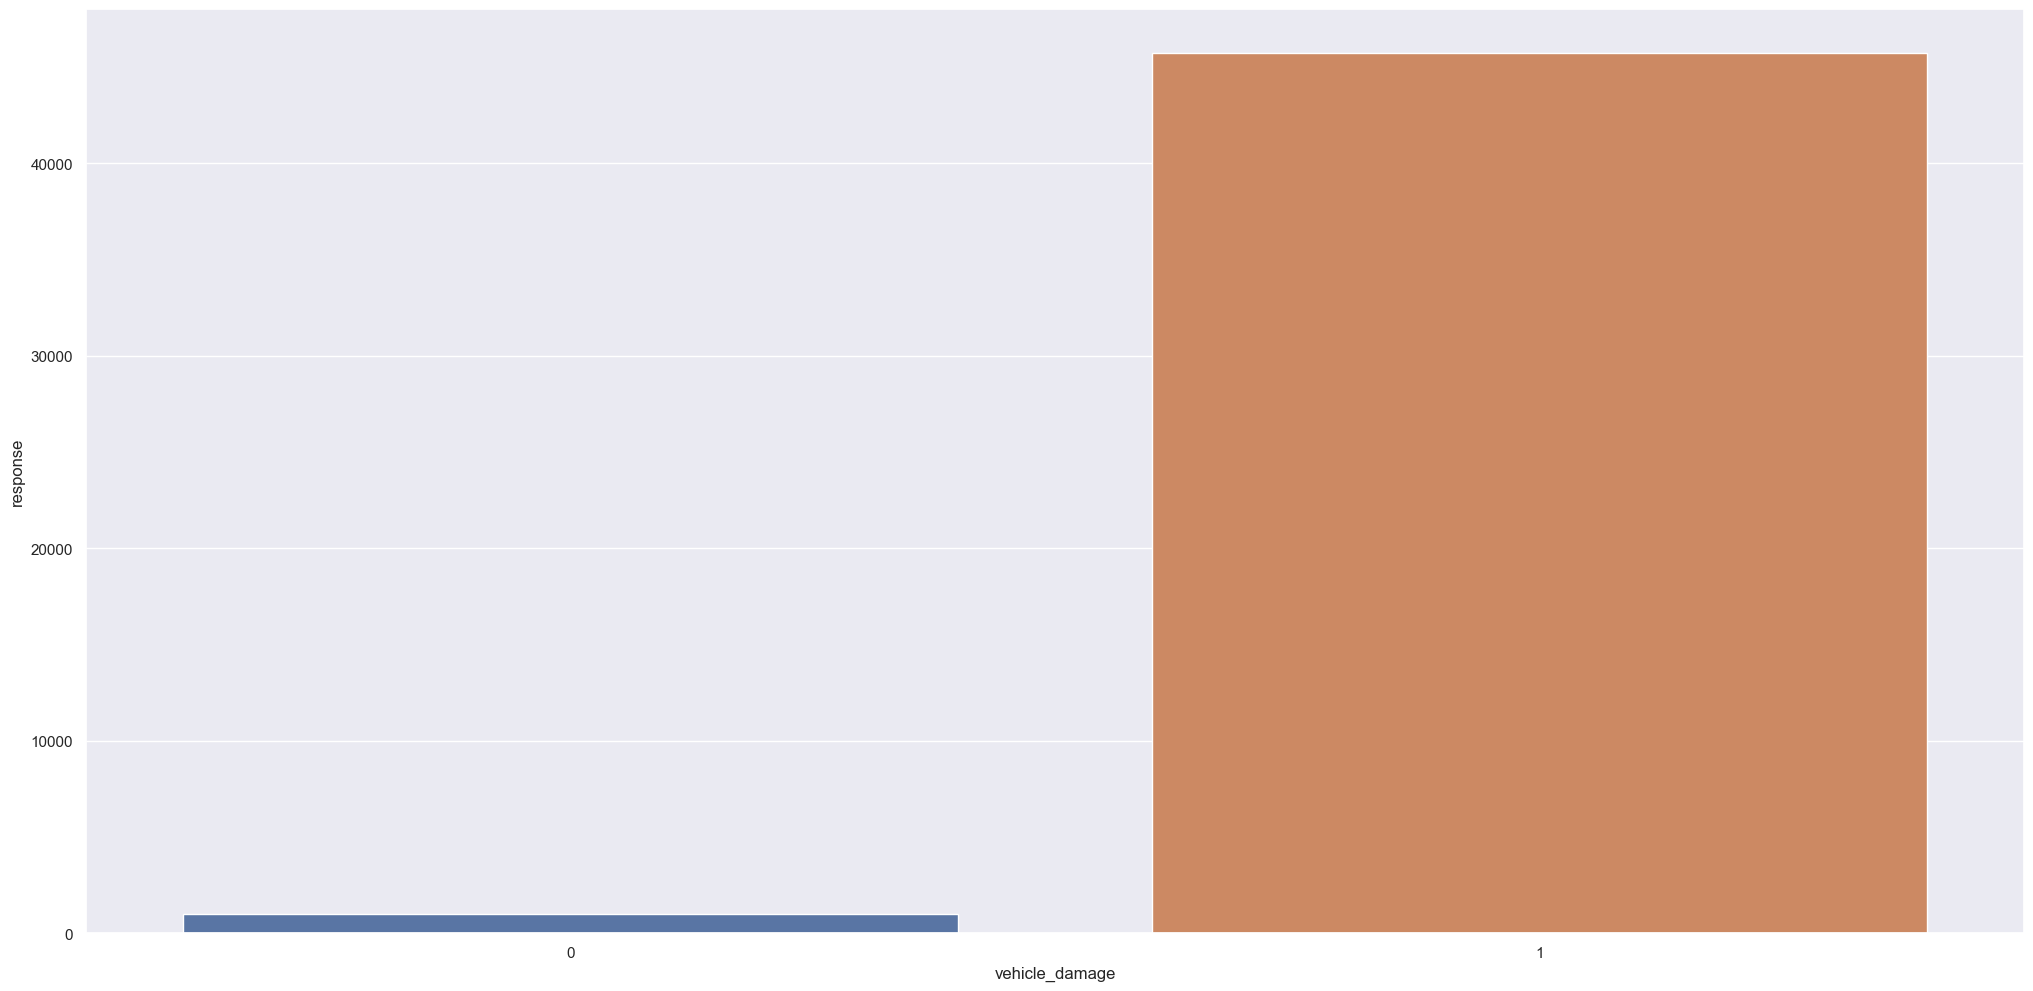

In [47]:
df_h5= df4[['vehicle_damage', 'response']][df4['response'] == 1].groupby('vehicle_damage').count().reset_index()

sns.barplot(x='vehicle_damage', y='response', data=df_h5);

**H6.** Clientes que já possuem algum seguro veicular aceitam menos o seguro veicular.

**RESPOSTA**: Essa afirmação é verdadeira

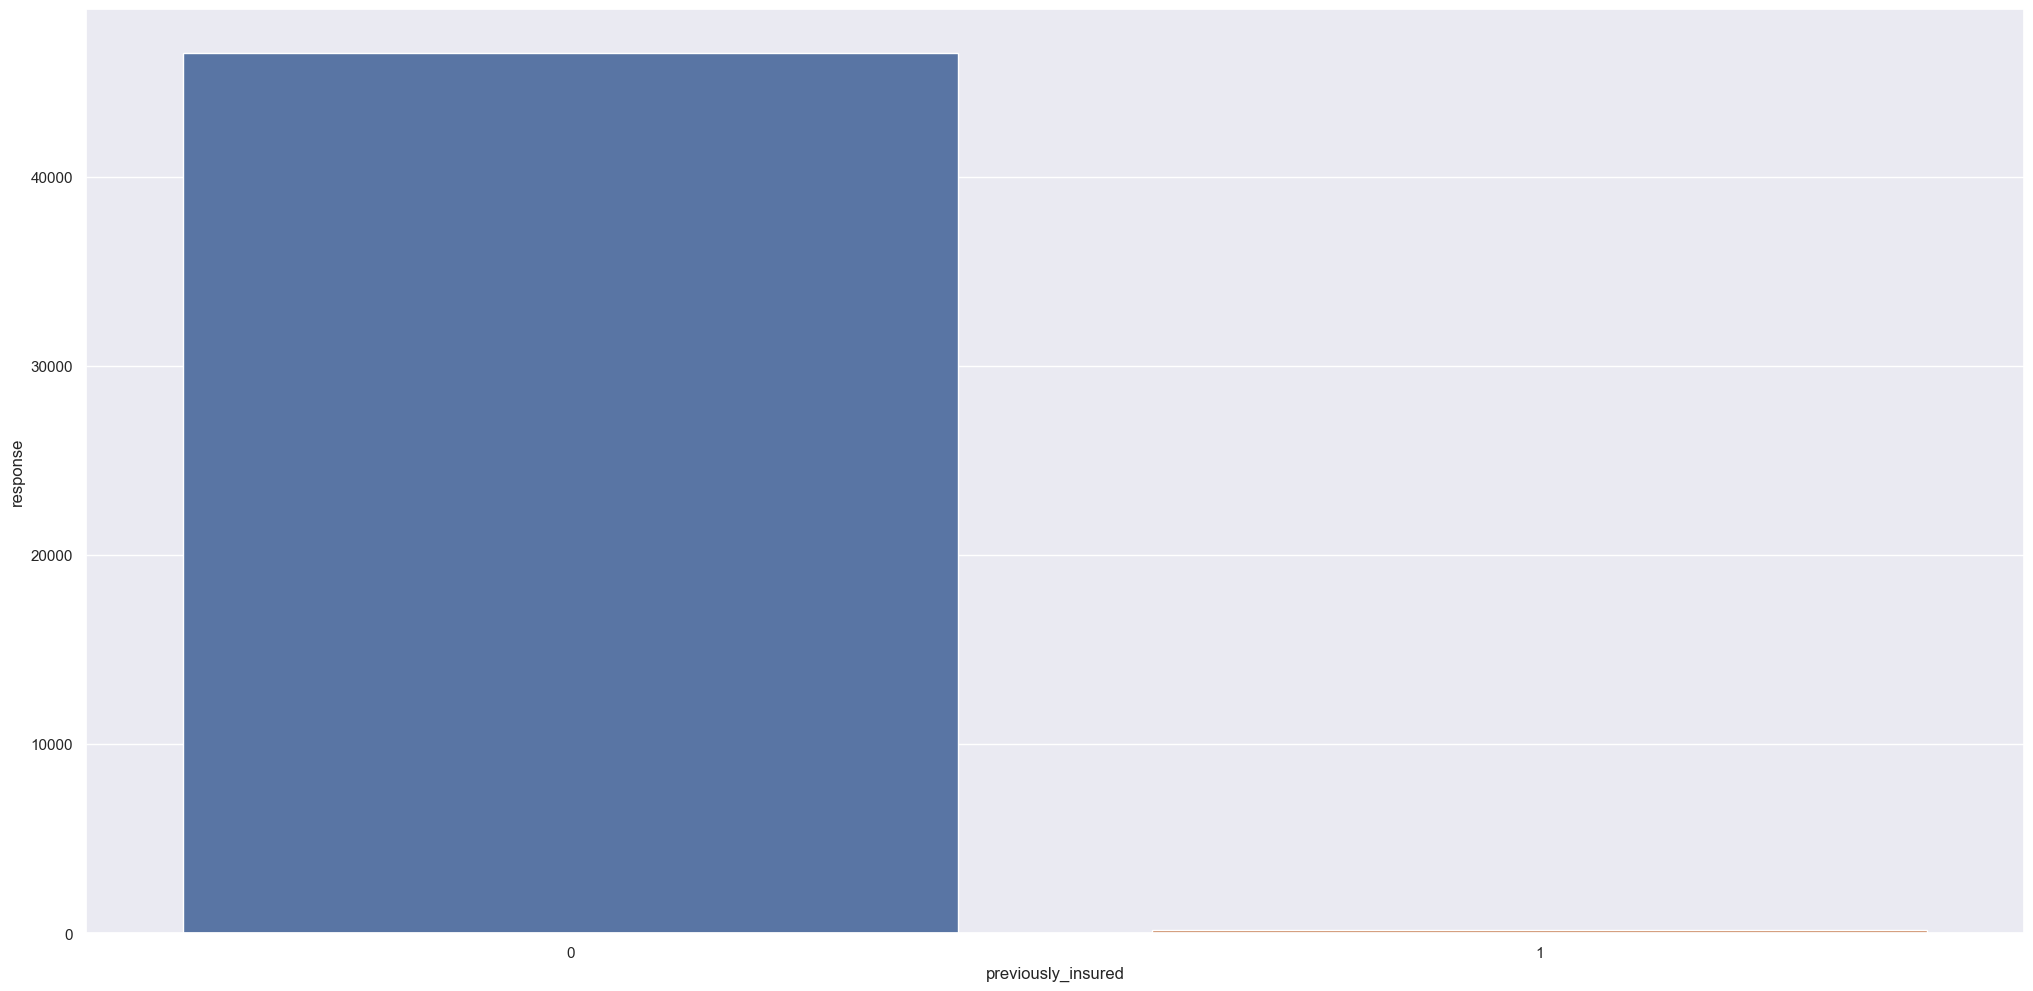

In [48]:
df_h6= df4[['previously_insured', 'response']][df4['response'] == 1].groupby('previously_insured').count().reset_index()

sns.barplot(x='previously_insured', y='response', data=df_h6);

(pendente)**H7.** Clientes com annual_premium menor que 35.000,00 aceitam menos o seguro veicular.

**H8.** Clientes que estão a mais tempo com a empresa aceitam mais o seguro veicular.

**RESPOSTA:** Essa afirmação é falsa. Temos uma hogeneidade nos dados gerando uma inconclusão.

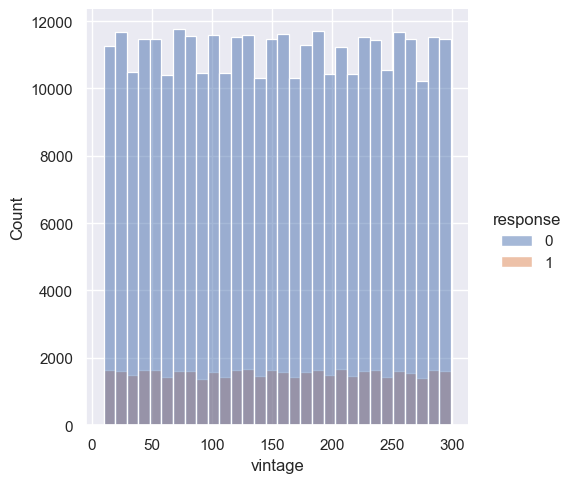

In [49]:
df_h8 = df4[['vintage', 'response']]

sns.displot(data=df_h8, x='vintage', hue='response', bins=30);

**H9.** Clientes com idade acima de 40 anos aceitam mais o seguro veicular

**RESPOSTA:** Essa afirmação é verdadeira. Melhor ainda, clientes que estão na faixa de idade de 30 a 50 anos aceiram mais o plano de saúde.

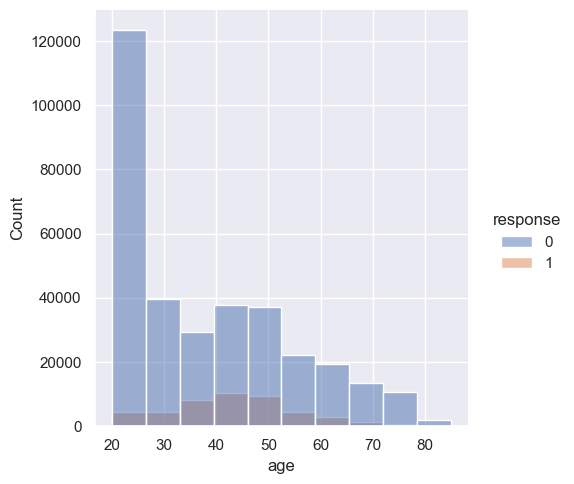

In [50]:
df_h8 = df4[['age', 'response']]

sns.displot(data=df_h8, x='age', hue='response', bins=10);

## 4.4 Resumo das Hipóteses

In [51]:
tab = [['Variável', 'Relevancia'], 
       ['annual_premium', 'Alta'],
       ['vintage', 'Alta'],
       ['age', 'Alta'],
       ['policy_sales_channel', 'Alta'],
       ['region_code', 'Alta'],
       ['previously_insured', 'Media'],
       ['driving_license', 'Baixa'],]

print(tabulate(tab, headers='firstrow'))

Variável              Relevancia
--------------------  ------------
annual_premium        Alta
vintage               Alta
age                   Alta
policy_sales_channel  Alta
region_code           Alta
previously_insured    Media
driving_license       Baixa


# 5.0. Passo 5 - Preparação dos Dados

In [52]:
df5 = df4.copy()

## 5.1 Standarlazing

In [53]:
#'annual_premium'

# método utlizado para padronização
ss = pp.StandardScaler()

# variável annual_premium padronizada
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 5.2 Rescaling

In [54]:
# variável 'age' - MinMaxScaler
mms_age = pp.MinMaxScaler()
df5['age'] = mms_age.fit_transform(df5[['age']].values)


# avriável 'vintage' - MinMaxScaler
mms_vintage = pp.MinMaxScaler()
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)


## 5.2 Encoder


In [55]:
#'region_code' - Frequencily Enconding
fe_encode_region_code = df5.groupby('region_code').size()/len(df5)
df5.loc[ : , 'region_code'] = df5['region_code'].map(fe_encode_region_code)

#'vehicle_age' - Order Enconding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

#'policy_sales_channel' - Target Enconding/ Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len(df5)
df5.loc[ : , 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

#'gender' - Frequencily Encoding
fe_encode_gender = df5.groupby('gender').size()/len(df5)
df5.loc[ : , 'gender'] = df5['gender'].map(fe_encode_gender)

C:\Users\Xcell\AppData\Local\Temp\ipykernel_380\1832818468.py:14: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df5.loc[ : , 'gender'] = df5['gender'].map(fe_encode_gender)


# 6.0. Passo 6 - Seleção das Features 

In [56]:
df6 = df5.copy()

## 6.1 - Validation/train datasets

In [57]:
# Separação dos sets
X = df5.drop('response', axis=1)
Y = df5['response'].copy()

# construção dos dataframes de treino e validação
x_train, x_val, y_train, y_val = ms.train_test_split(X, Y, test_size=0.25)

# dataset performance
x_performance = x_val.copy()

# dataset train
df6 = pd.concat([x_train, y_train], axis=1)

## 6.2 Feature Selections

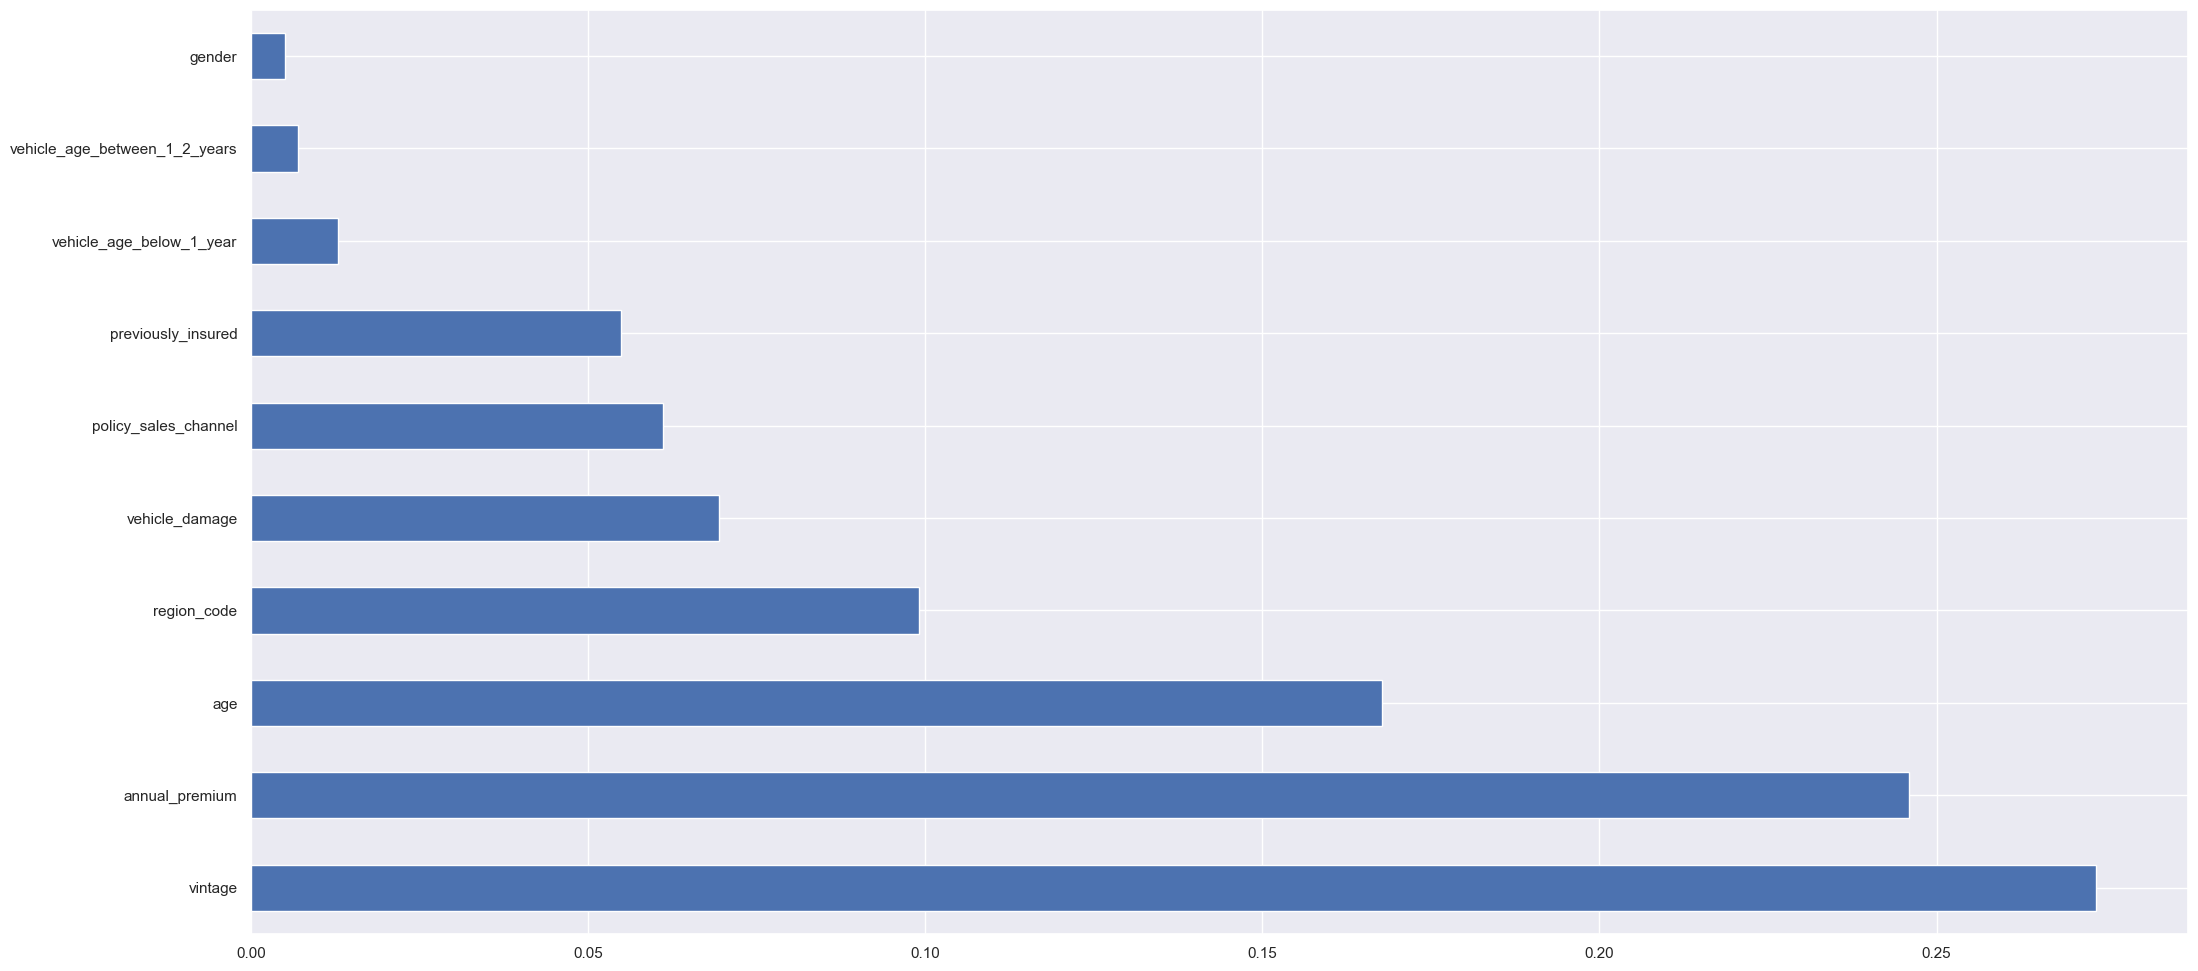

In [58]:
# Preparação do Classificador
forest = en.ExtraTreesClassifier(n_estimators=500, random_state=42, n_jobs=-1)

# Preparação do dataset_train
x_train_n = df6.drop(columns=['id', 'response'], axis=1)
y_train_n = df6['response'].values

# Seleção das Features Relevantes
selection_features = forest.fit(x_train_n, y_train_n)

# Exibição em gráfico das features selecionadas.
feat_importances = pd.Series(selection_features.feature_importances_, index=x_train_n.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [60]:
feat_importances.sort_values(ascending=False)

vintage                          0.273653
annual_premium                   0.245909
age                              0.167768
region_code                      0.099039
vehicle_damage                   0.069498
policy_sales_channel             0.061146
previously_insured               0.054868
vehicle_age_below_1_year         0.012925
vehicle_age_between_1_2_years    0.006937
gender                           0.005141
vehicle_age_over_2_years         0.002633
driving_license                  0.000484
dtype: float64

In [61]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

cols_selected_full = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured', 'response']

# 7.0. Passo07 - Machine Learning Models

In [62]:
# Seleção dos Dataframes para validação e testes;

x_train = x_train[cols_selected]
x_val   = x_val[cols_selected]
data_training = df6[cols_selected_full]

## 7.1 KNN 

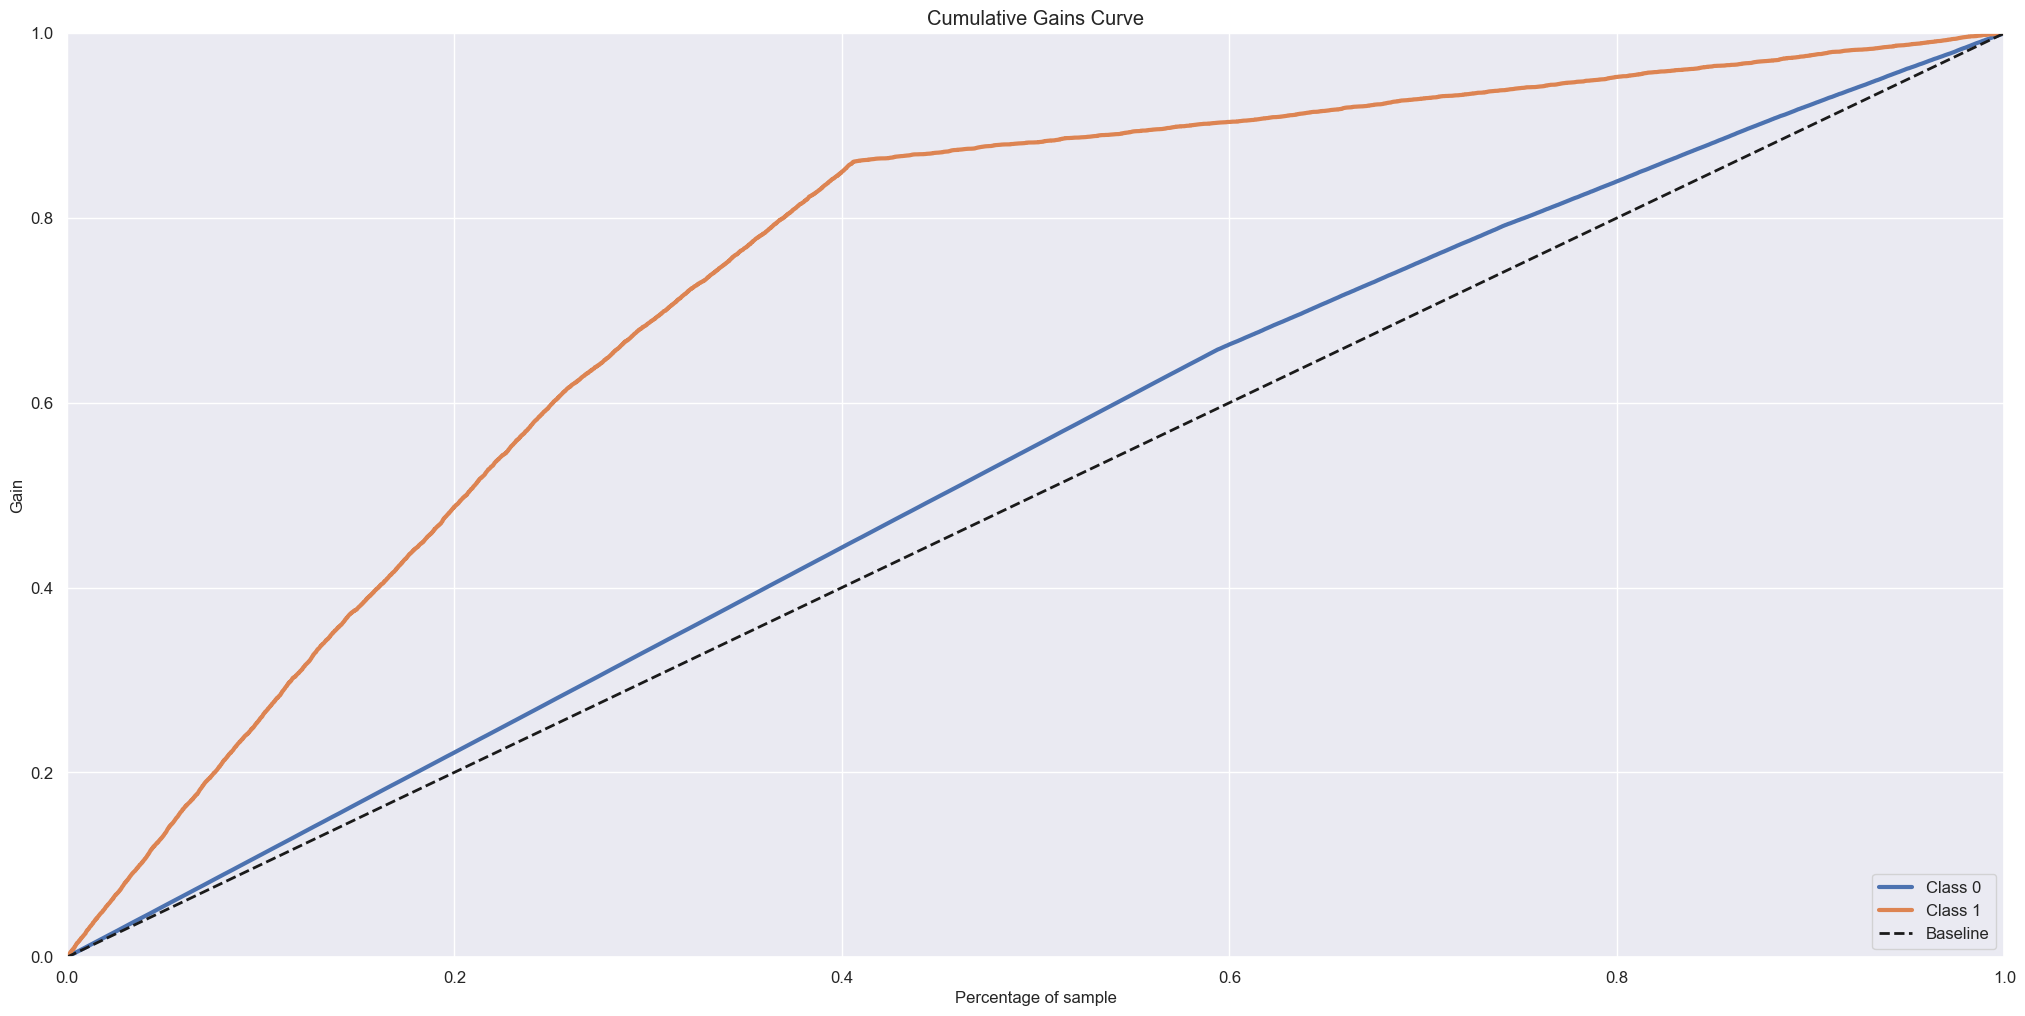

In [63]:
# Model with 7 neighbours
knn_model = nb.KNeighborsClassifier(n_neighbors=7, n_jobs=-1)

# Treino
knn_model.fit(x_train, y_train)

# Predição para a construção do cumulative gains
yhat_knn_proba = knn_model.predict_proba(x_val)
yhat_knn = knn_model.predict(x_val)

# Gráfico
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn_proba);

### 7.1.1 KNN CrossValidation

In [64]:
# Cross_validation
knn_model_cv = pd.DataFrame(cross_validation(data_training, 'KNN Model', knn_model, 5), index=[0])
knn_model_cv

,model_name,precision,recall
0,KNN Model,0.209,0.896


# 7.2 XGBClassifier

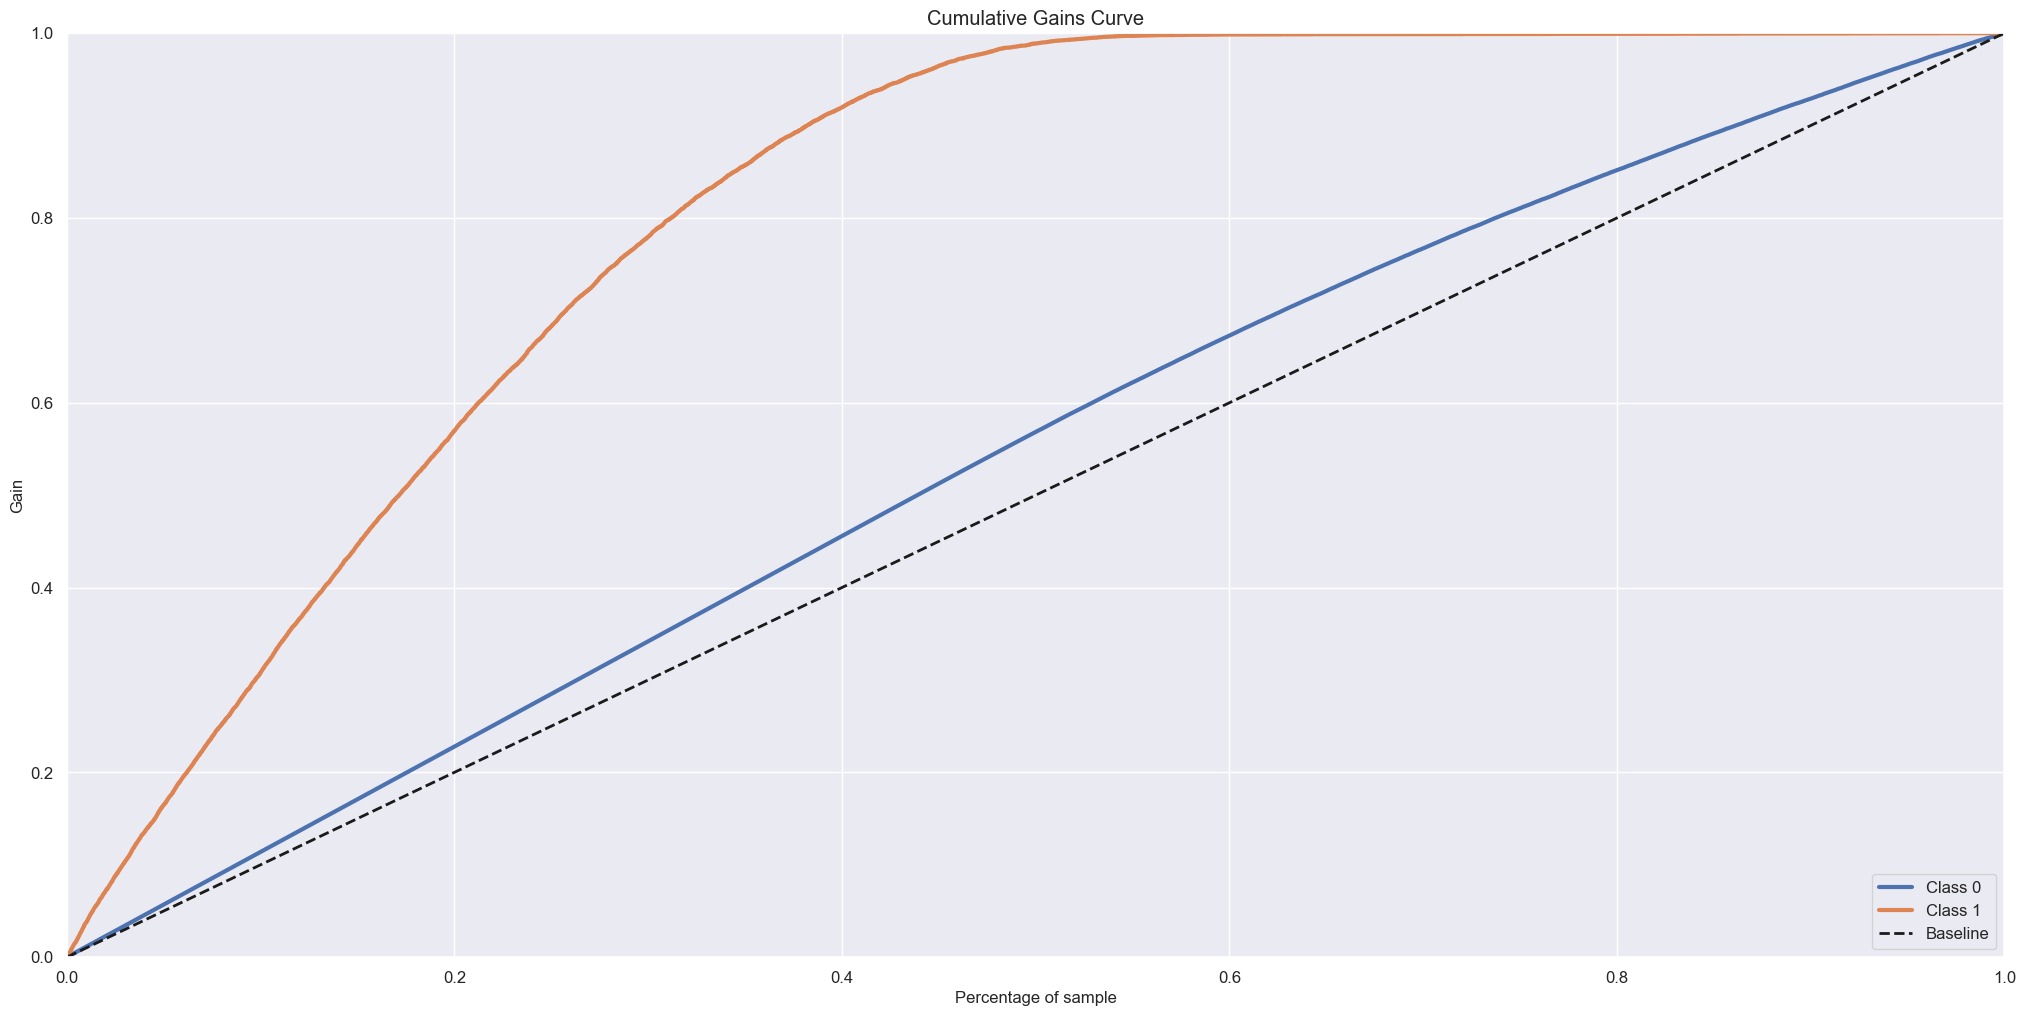

In [74]:
# Model with 7 neighbours
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, n_jobs=-1)

# Treino
xgb_model.fit(x_train, y_train)

# Predição para a construção do cumulative gains
yhat_xgb_proba = xgb_model.predict_proba(x_val)
yhat_xgb = xgb_model.predict(x_val)

# Gráfico
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb_proba);

### 7.2.1 XGB CrossValidation

In [75]:
# Cross_validation
xgb_model_cv = pd.DataFrame(cross_validation(data_training, 'XGBClassifier Model', xgb_model, 5), index=[0])
xgb_model_cv

,model_name,precision,recall
0,XGBClassifier Model,0.232,0.994


## 7.3 ExtraTreesClassifier

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

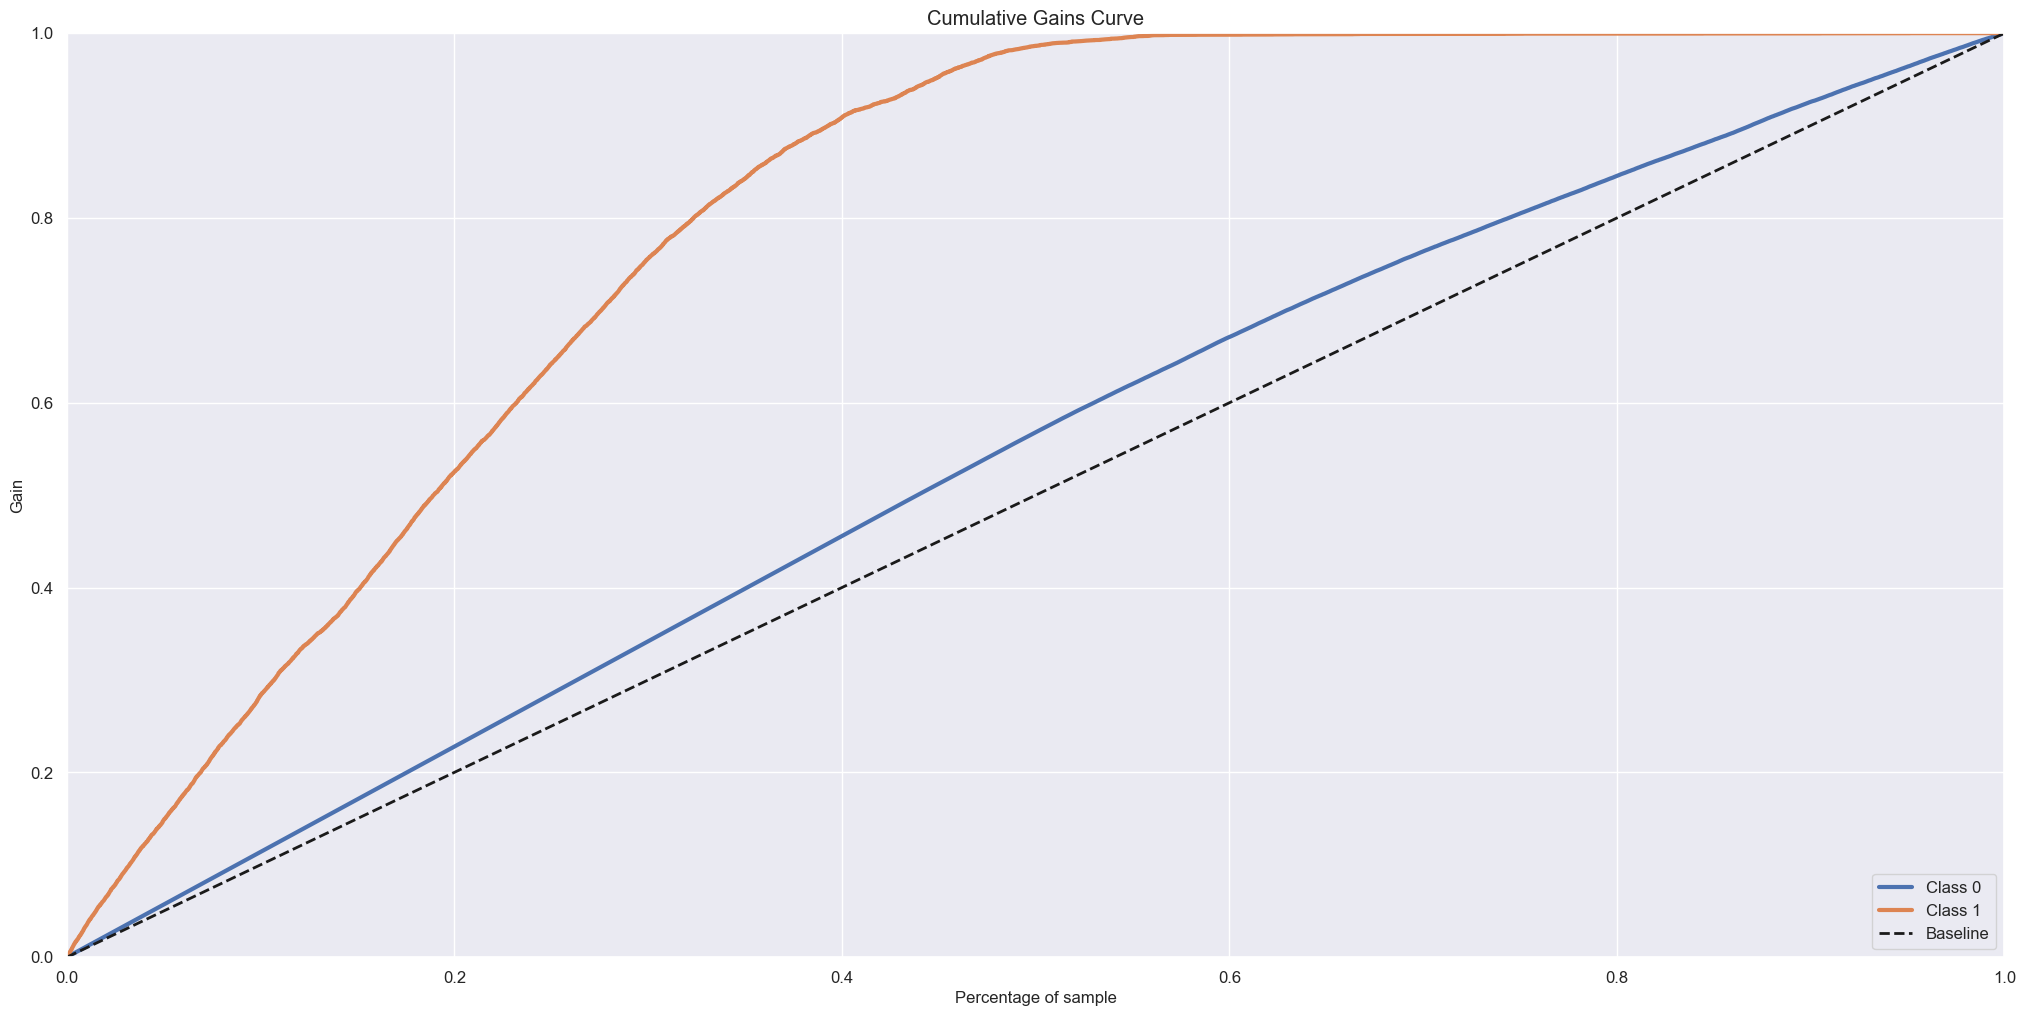

In [76]:
# model
et_model = en.ExtraTreesClassifier(n_estimators=100, max_depth=5, n_jobs=-1)

# Treino
et_model.fit(x_train, y_train)

# Predição para a cumuative gains curve
yhat_et_proba = et_model.predict_proba(x_val)

# Predição para o precision e recall
yhat_et = et_model.predict(x_val)

# Cumulative Gains Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_et_proba)

### 7.3.1 ExtraTreesClassifier CrossValidation

In [77]:
# Cross_validation
et_model_cv = pd.DataFrame(cross_validation(data_training, 'ExtraTreesClassifier Model', et_model, 5), index=[0])
et_model_cv

,model_name,precision,recall
0,ExtraTreesClassifier Model,0.232,0.992


## 7.4 LogisticRegressor

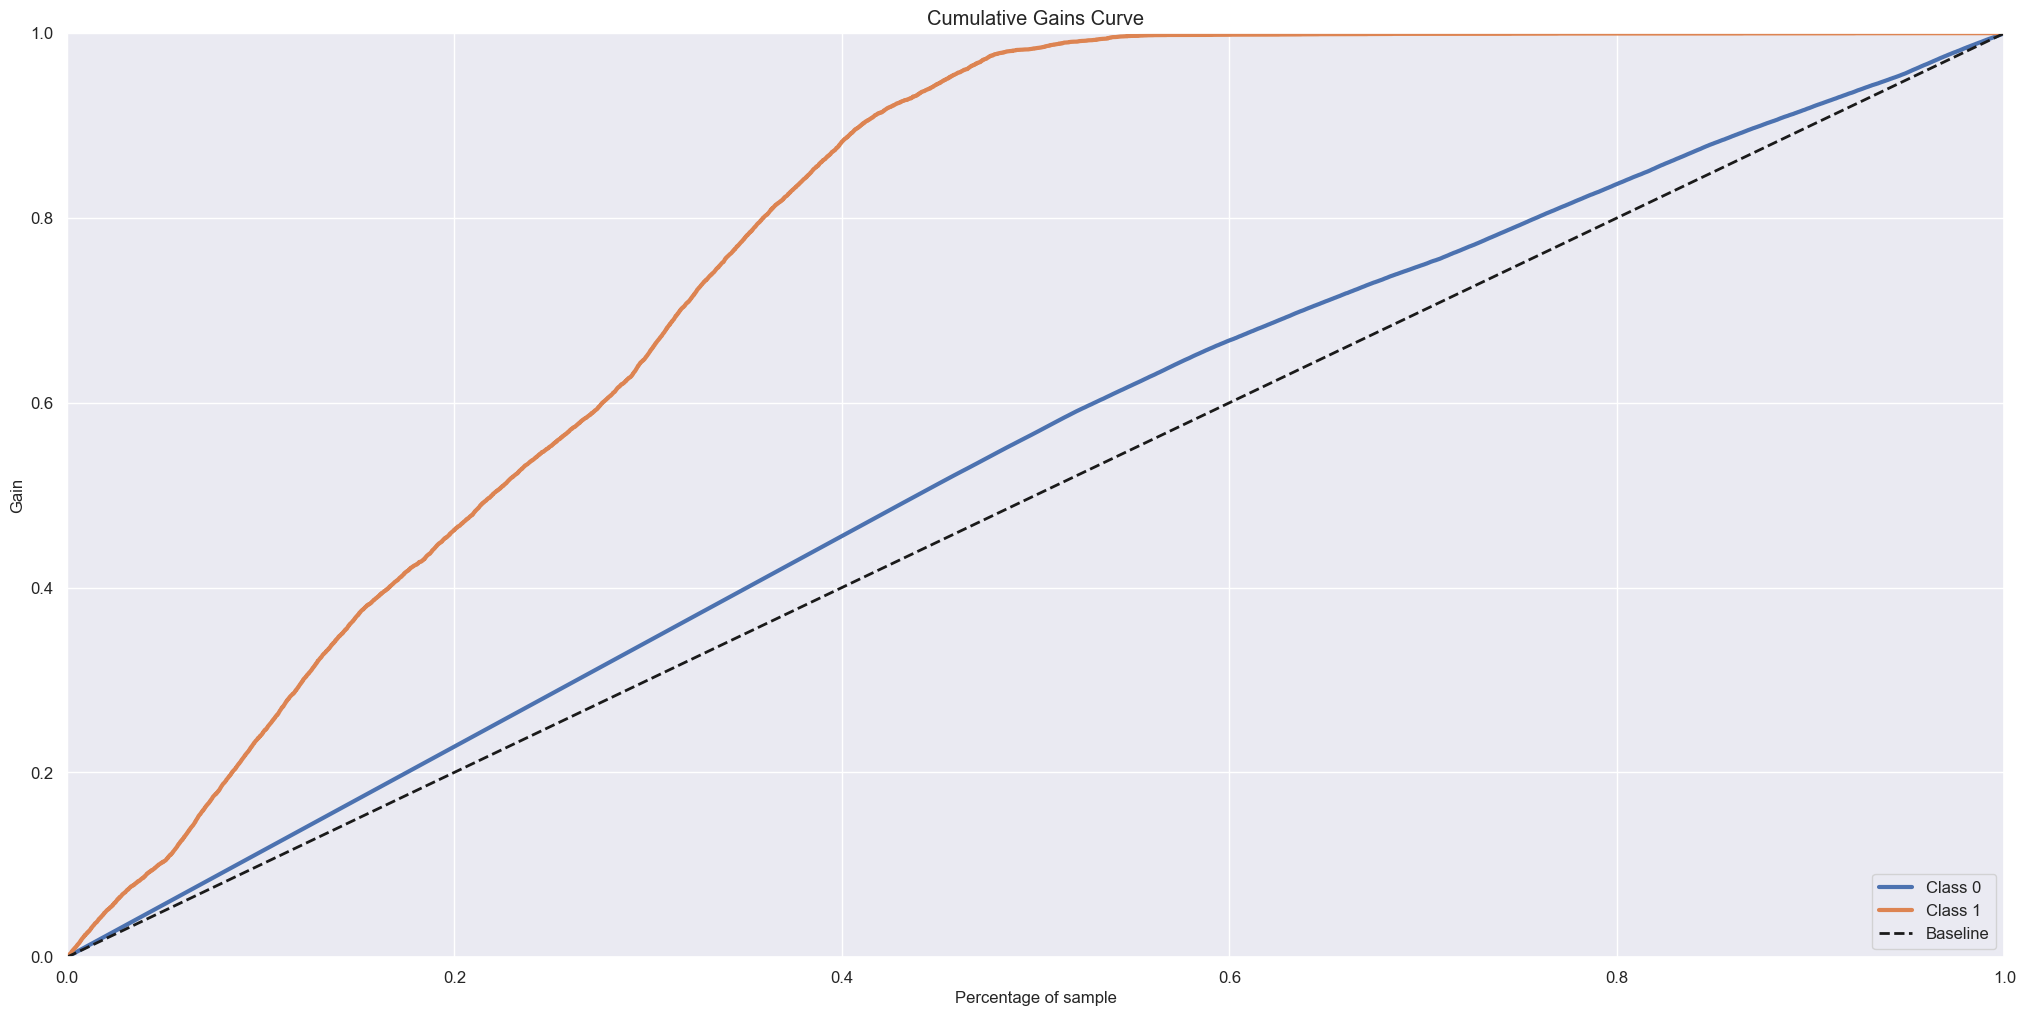

In [83]:
# Modelo
logreg = lm.LogisticRegression()

# Treino
logreg.fit(x_train, y_train)

# Predicao para a cumulative gains
yhat_logreg_proba = logreg.predict_proba(x_val)

# cumulativa gains curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_logreg_proba);

### 7.4.1 LogisticRegression CrossValidation

In [84]:
# Cross_validation
logreg_model_cv = pd.DataFrame(cross_validation(data_training, 'LogisticRegressor Model', logreg, 5), index=[0])
logreg_model_cv

,model_name,precision,recall
0,LogisticRegressor Model,0.232,0.993


## 7.5 Random Forest Classifier

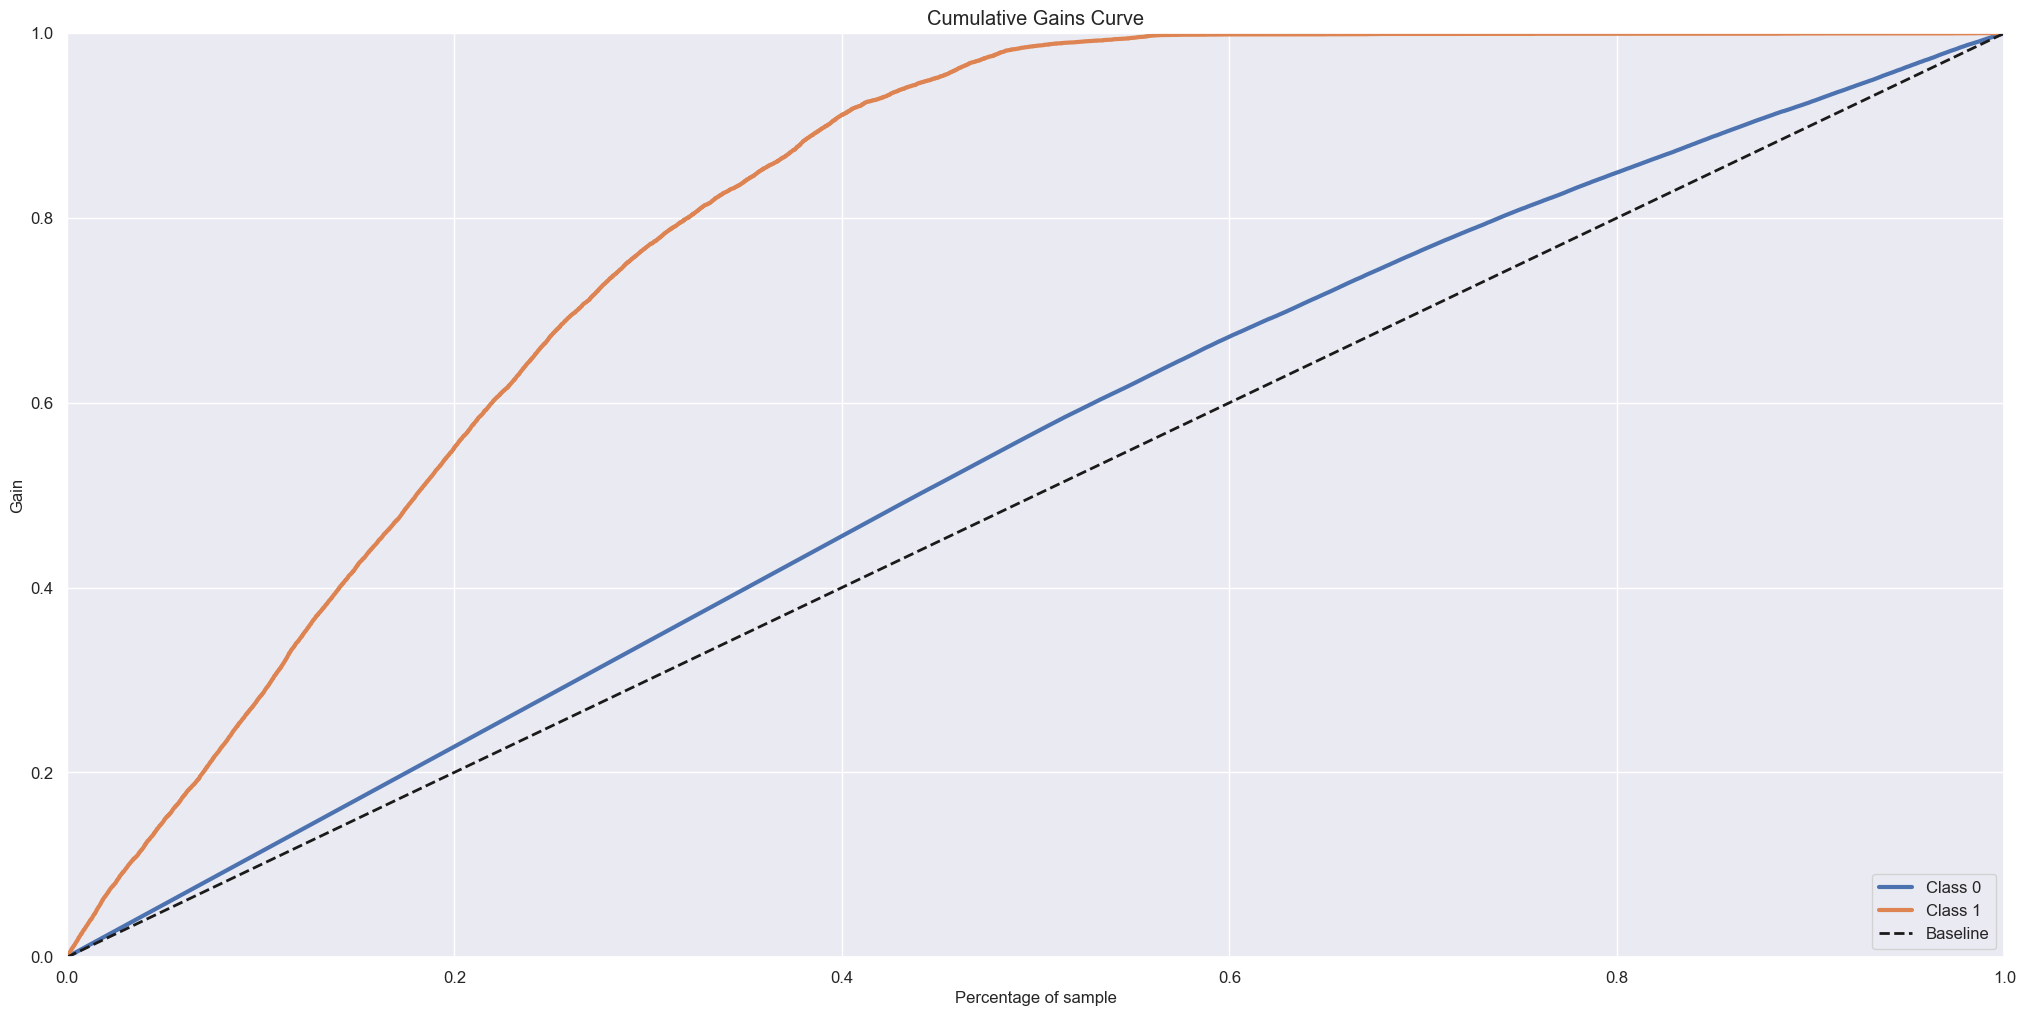

In [80]:
# Model
rf_model = en.RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Treino
rf_model.fit(x_train, y_train)

# Predição para a cumulative gains curve
yhat_rf_proba = rf_model.predict_proba(x_val)

# Gráfico
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf_proba);

### 7.5.1 RandomForestClassifier CrossValidation

In [81]:
# Cross_validation
rf_model_cv = pd.DataFrame(cross_validation(data_training, 'RandomForestClassifier Model', rf_model, 5), index=[0])
rf_model_cv

,model_name,precision,recall
0,RandomForestClassifier Model,0.232,0.992


## 7.6 - Performance dos Modelos

In [85]:
pd.concat([knn_model_cv, xgb_model_cv, et_model_cv, logreg_model_cv, rf_model_cv], axis=0)

,model_name,precision,recall
0,KNN Model,0.209,0.896
0,XGBClassifier Model,0.232,0.994
0,ExtraTreesClassifier Model,0.232,0.992
0,LogisticRegressor Model,0.232,0.993
0,RandomForestClassifier Model,0.232,0.992


# 8.0. Passo 8.0 - Hyperparmater Fine Tunning 

In [71]:
param_grid = {'n_estimators': [250, 500, 750], 
              'eta': [0.01, 0.03], 
              'max_depth': [2, 4], 
              'subsample': [0.1, 0.3], 
              'colsample_bytree': [0.3, 0.7]} 